In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xarray as xr
import numdifftools as ndt
from scipy import stats 

path = r"C:\Users\user\Victor\Trabajo\NoEstacionario\Python"
os.chdir(path)
os.getcwd()

'C:\\Users\\user\\Victor\\Trabajo\\NoEstacionario\\Python'

In [2]:
data = pd.read_table("Datos\\DatosSimulados_10000y\\Hs_SS_PCs_FWT_LWT_Precip_Cantabria_reg_guided.txt")

In [3]:
# Columns for the Hs dataframe
cols_first = ['yyyy', 'mm', 'dd', 'Hs'] + [col for col in data.columns if col.startswith('PC') and not col.endswith('_SS')] + ['FWT']

# Columns for the Surge dataframe
cols_second = ['yyyy', 'mm', 'dd', 'Surge'] + [col for col in data.columns if col.endswith('_SS')] + ['LWT']

# Create the two DataFrames
df_hs = data[cols_first]
df_surge = data[cols_second]

In [4]:
# Define the days in a month dictionary
days_in_month = {1: 31, 2: 28.25, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

# Correct the time assignment for df_hs
df_hs = df_hs.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_hs['time'] = (
    df_hs['yyyy'] - np.min(df_hs['yyyy'])
    + (df_hs['mm'] - 1) / 12
    + df_hs['dd'] / df_hs['mm'].map(days_in_month) / 12
)

# Correct the time assignment for df_surge
df_surge = df_surge.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_surge['time'] = (
    df_surge['yyyy'] - np.min(df_surge['yyyy'])
    + (df_surge['mm'] - 1) / 12
    + df_surge['dd'] / df_surge['mm'].map(days_in_month) / 12
)

# Análisis para Hs por WT

In [5]:
wt_probs = df_hs['FWT'].value_counts(normalize=True).sort_index()
wt_range = np.sort(df_hs['FWT'].unique())

Diccionario con un DataFrame asociado a cada WT distinto.

In [6]:
dict_hs = {}
for idx_wt, wt in enumerate(wt_range):
    dict_hs[idx_wt] = df_hs[:][df_hs['FWT'] == idx_wt]

In [7]:
# Yearly maxima
hsmax_data = {}
max_idx = {}

for idx_wt, wt in enumerate(wt_range):
    hsmax_data[idx_wt] = dict_hs[idx_wt].groupby(["yyyy"], as_index=False)["Hs"].max()  # Máximo anual Hs para cada WT
    max_idx[idx_wt] = dict_hs[idx_wt].groupby(["yyyy"])["Hs"].idxmax().values           # Indice del máximo anual por WT
n_return_period = 365.25

In [8]:
n_return_period = 365.25*wt_probs

Datos ordenados

In [9]:
hsmax_data_sorted = {}
sorted_max_idx = {}
for idx_wt, wt in enumerate(wt_range):
    hsmax_data_sorted[idx_wt] = np.sort(hsmax_data[idx_wt]['Hs'])
    sorted_max_idx[idx_wt] = np.argsort(hsmax_data[idx_wt]['Hs'])

Point-in-time data

In [ ]:
hspt = {}
hspt_sort = {}
# Hs point-in-time data per WT
for idx_wt, wt in enumerate(wt_range):
    hspt[idx_wt] = dict_hs[idx_wt]['Hs'].values
    hspt_sort[idx_wt] = np.sort(dict_hs[idx_wt]['Hs'].values)

Cálculo de las ECDF y el periodo de retorno para cada WT

In [11]:
ecdf_pt_probs= {}
T_pt = {}
ecdf_ev_probs_wt = {}
T_ev_wt = {}

for idx_wt, wt in enumerate(wt_range):
    # Empirical df and Return period for point in time
    ecdf_pt_probs[idx_wt] = np.arange(1,len(hspt[idx_wt])+1)/(len(hspt[idx_wt])+1)
    T_pt[idx_wt] = 1/(1-ecdf_pt_probs[idx_wt])/n_return_period[idx_wt]

    # Empirical df and Return period for monthly maxima
    ecdf_ev_probs_wt[idx_wt] = np.arange(1,len(hsmax_data[idx_wt])+1)/(len(hsmax_data[idx_wt])+1)
    T_ev_wt[idx_wt] = 1/(1-ecdf_ev_probs_wt[idx_wt])

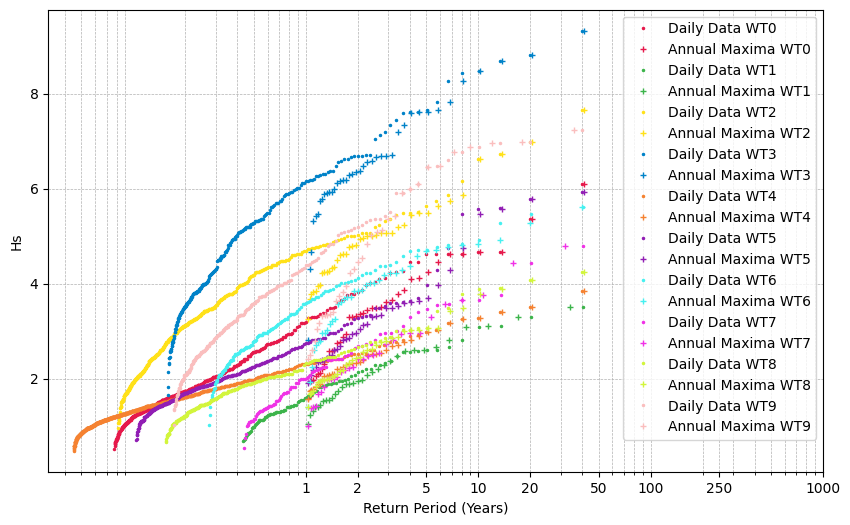

In [12]:
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff',
    '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000080', '#808080', '#ffffff', '#000000', '#ff0000', '#00ff00',
    '#0000ff', '#ffff00', '#ff00ff', '#00ffff', '#800080', '#ff4500',
    '#8b0000', '#008000', '#4682b4', '#d2691e', '#ff1493', '#6495ed'
]


fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot()
for idx_wt in range(10):
    ax.semilogx(T_pt[idx_wt], hspt_sort[idx_wt], linewidth=0, color=colors[idx_wt], marker='o',markersize=1.5, label=f'Daily Data WT{idx_wt}')
    ax.semilogx(T_ev_wt[idx_wt], hsmax_data_sorted[idx_wt], color=colors[idx_wt], linewidth=0, marker='+',markersize=5, label=f'Annual Maxima WT{idx_wt}')

# Configurar escala logarítmica y ticks personalizados
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mantiene los números sin notación científica

# Etiquetas y grid
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostrar gráfico
plt.legend()
plt.show()

# Corrección Extremos en Bloques usando la clase ya creada

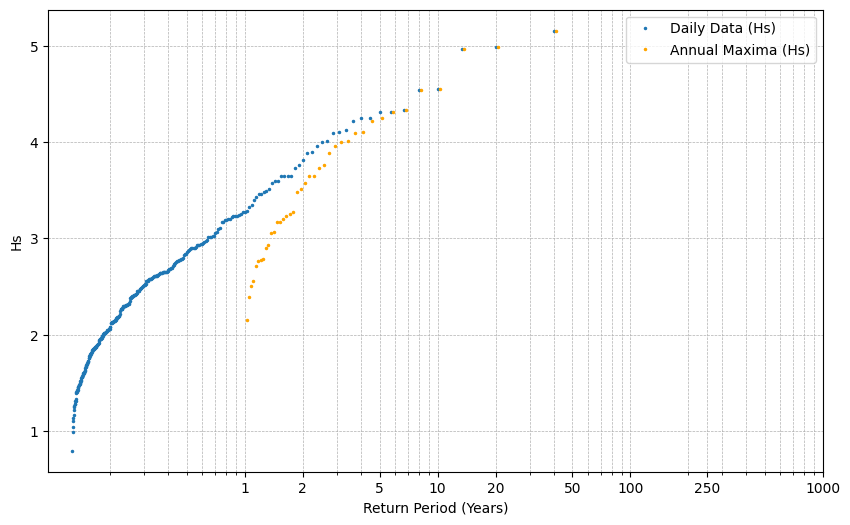

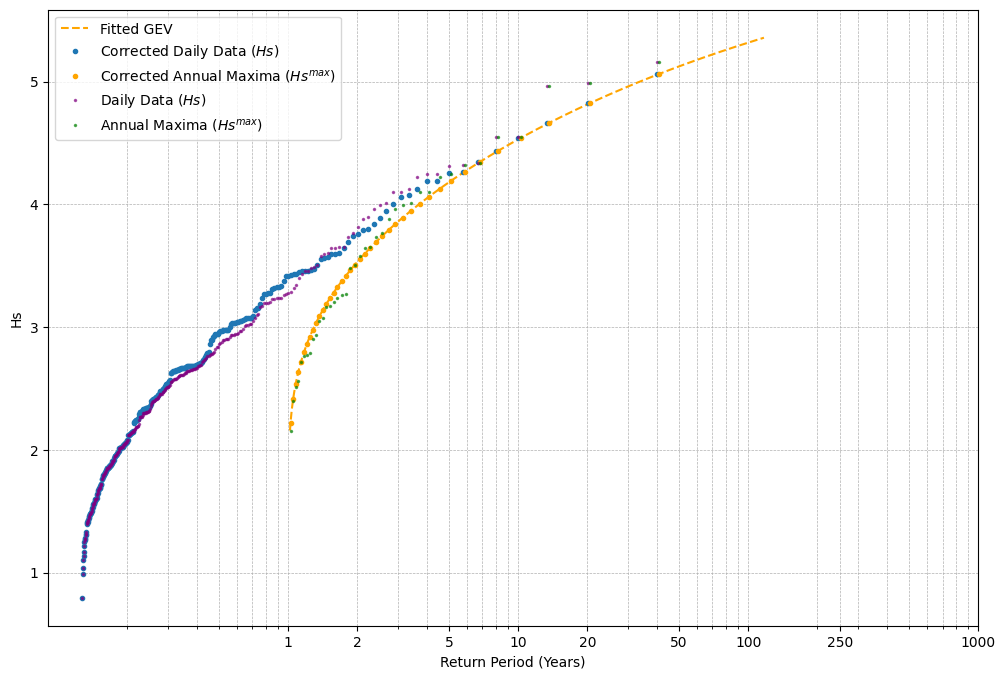

In [16]:
from ExtremePOT_Correction.extremecorrection import ExtremeCorrection

# for idx_wt, wt in enumerate(wt_range):
idx_wt=11
extremecorr = ExtremeCorrection(dict_hs[idx_wt], frequency=n_return_period[idx_wt])
extremecorr.return_period_plot()

output_dir = "Figuras/WT_Hs"
os.makedirs(output_dir, exist_ok=True)

fig = extremecorr.return_period_plot_corrected(without_corr=True)  # Generar gráfico

fig.savefig(f"{output_dir}/ReturnPeriod_WT{idx_wt}.png", dpi=200, bbox_inches='tight')
# extremecorr.plot_ts()

# Ajuste de Pareto-Poisson a cada WT

## Selección del threshold óptimo

In [17]:
from OptimalThresholdSelection.optimal_threshold_studentized import OptimalThreshold

### Selección del umbral óptimo para los datos completos sin división por WT

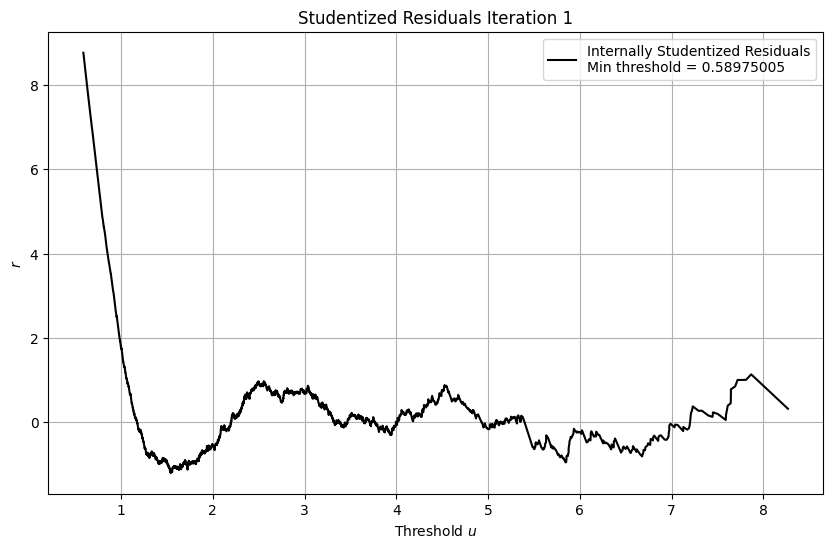

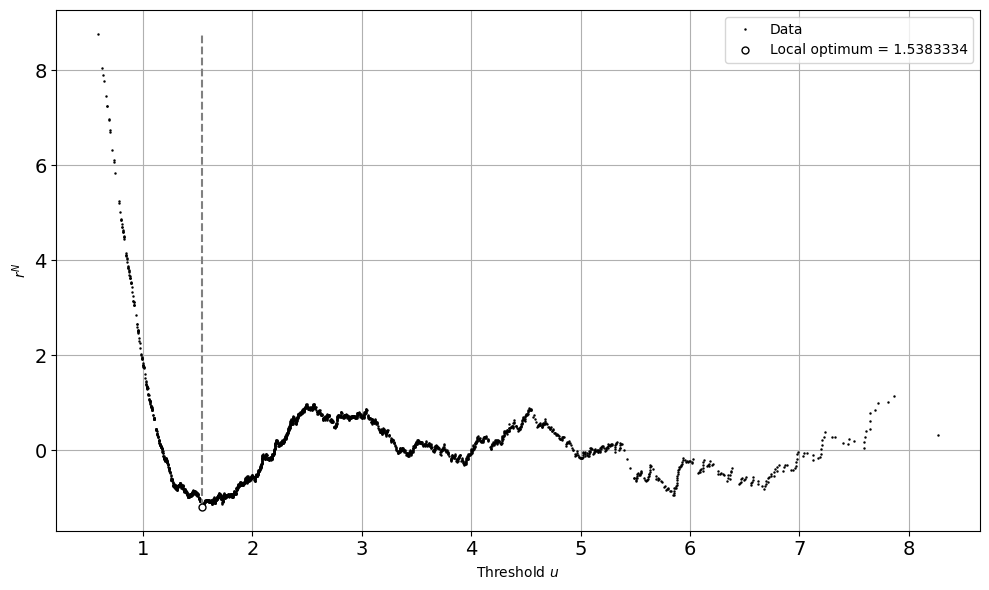

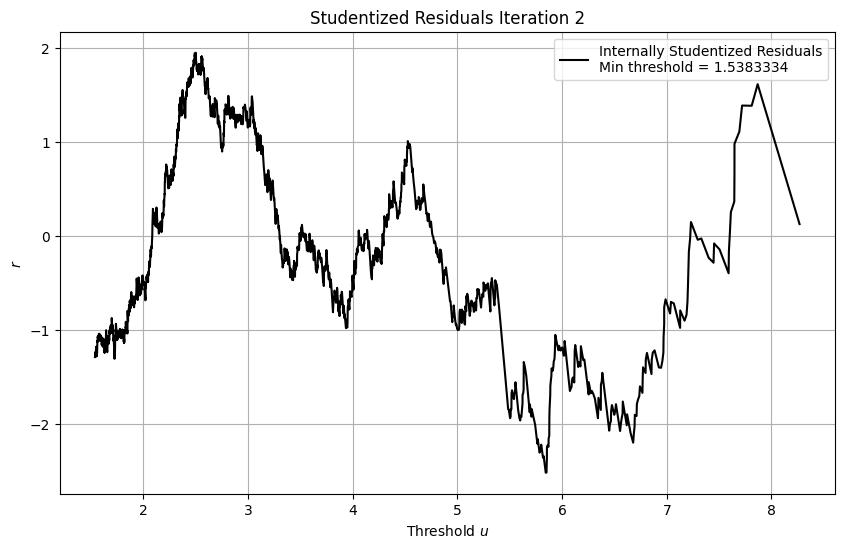

[1.5383334]


In [18]:
threshold = 0.0
n0 = 10
min_peak_distance = 2   # 2 días de distancia entre picos
siglevel=0.05

# Inicializar la clase
opt_thres = OptimalThreshold(data=df_hs['Hs'].values)
# Obtener los picos
opt_thres.threshold_peak_extraction(threshold=0,
                                    n0=n0,
                                    min_peak_distance=min_peak_distance)

# Crear carpeta si no existe
folder_path = "Figuras/PruebaOptThreshold/"
os.makedirs(folder_path, exist_ok=True)

# Obtener el threshold óptimo
threshold = opt_thres.threshold_studentized_residuals(siglevel=siglevel,
                                                      plot_flag=True,
                                                      filename=f"{folder_path}HsDiario",
                                                      display_flag=False)
print(threshold)

### Selección del threshold óptimo para cada WT

Primero dividimos los datos por WT y le asignamos el valor 0 a los datos en los que no aparezca ese WT

In [19]:
# Copiar solo las columnas PC0,..., PC99 y 'time' del DataFrame original
cols_pc = [col for col in df_hs.columns if col.startswith("PC")] + ['time', 'FWT']
df_rwt = df_hs[cols_pc].copy()

# Obtener valores únicos de FWT
unique_rwt = df_hs['FWT'].unique()

# Crear nuevas columnas Hs_FWT0, Hs_FWT1, ..., Hs_FWTn
for wt in unique_rwt:
    df_rwt[f'Hs_FWT{int(wt)}'] = df_hs['Hs'].where(df_hs['FWT'] == wt, 0)

#### Obtenemos el threshold óptimo para cada WT usando la clase creada

In [20]:
# Por si se quiere usar quantiles para determinar el threshold optimo
quantiles_998 = np.zeros(len(wt_range))
for wt in unique_rwt:
    quantiles_998[wt] = np.quantile(df_rwt[f'Hs_FWT{int(wt)}'].values, 0.998)

In [21]:
thresholds = np.zeros(len(wt_range))
picos = {}
pks = {}
n0 = 10
min_peak_distance = 2   # 2 días de distancia entre picos
siglevel = 0.05         # Nivel de confianza

for wt in unique_rwt[:-4]:
    # Inicializar la clase
    opt_thres = OptimalThreshold(data=df_rwt[f'Hs_FWT{int(wt)}'].values)
    # Obtener los picos
    opt_thres.threshold_peak_extraction(threshold=thresholds[wt],
                                        n0=n0,
                                        min_peak_distance=min_peak_distance)
    
    #picos[wt] = opt_thres.pks_unicos_valid
    picos[wt] = np.sort(opt_thres.pks)
    # Obtener el threshold óptimo
    thresholds[wt] = opt_thres.threshold_studentized_residuals(siglevel=siglevel).item()

In [22]:
poisson_parameter = np.zeros(len(wt_range))
for wt in unique_rwt[:-4]:
    poisson_parameter[wt] = len(picos[wt][picos[wt]>thresholds[wt]])/40

In [23]:
poisson_parameter

array([3.8  , 1.425, 6.05 , 2.125, 9.375, 5.   , 2.225, 0.   , 2.6  ,
       0.9  , 1.725, 3.475, 7.725, 0.725, 4.75 , 4.075, 0.   , 5.175,
       1.75 , 3.55 , 4.775, 3.5  , 1.675, 4.675, 1.45 , 8.65 , 8.575,
       3.825, 2.4  , 0.   , 6.325, 2.375, 0.   , 9.775, 2.525, 3.2  ])

#### Ajuste de Pareto para cada WT

In [24]:
from scipy.stats import genpareto

In [25]:
xi = np.zeros(len(wt_range))
loc = np.zeros(len(wt_range))
sigma = np.zeros(len(wt_range))

for wt in unique_rwt[:-4]:
    xi[wt], loc[wt], sigma[wt] = genpareto.fit(picos[wt][picos[wt]>thresholds[wt]]-thresholds[wt], floc=0)

In [26]:
folder_path = "Figuras/Hs/QQPlots"
os.makedirs(folder_path, exist_ok=True)

for wt in unique_rwt[:-4]:
    # Calcular cuantiles teóricos de la GPD ajustada
    n = len(picos[wt][picos[wt] > thresholds[wt]])
    probabilities = (np.arange(1, n + 1) - 0.5) / n  # Probabilidades de los cuantiles empíricos
    gpd_quantiles = genpareto.ppf(probabilities, xi[wt], loc=loc[wt], scale=sigma[wt])

    # Ordenar los datos observados para comparación con los cuantiles teóricos
    sorted_data = np.sort(picos[wt][picos[wt] > thresholds[wt]])

    # Crear el QQ-plot
    plt.figure(figsize=(7, 7))
    plt.scatter(gpd_quantiles, sorted_data, label="Datos vs. GPD", alpha=0.7)
    plt.plot(gpd_quantiles, gpd_quantiles, 'r--', label="y = x (Referencia)")

    # Etiquetas
    plt.xlabel("Cuantiles Teóricos (GPD ajustada)")
    plt.ylabel("Cuantiles Empíricos (Datos)")
    plt.title("QQ-plot: Ajuste de la GPD a los Datos")
    plt.legend()
    plt.grid()
    plt.savefig(f"{folder_path}/QQPlot_{wt}.png", dpi=200)
    plt.close()

### Corrección Extremal para cada WT

In [27]:
def qgpd(prob,threshold,xi,sigma):
    return genpareto.ppf(prob, c=xi, loc=threshold, scale=sigma)

In [28]:
# Defining dictionary to store all the data for differents WT
ecdf_pot_probs = {}
hs_pot_wt0_corrected = {}
hs_wt0_corrected = {}
ecdf_pot_probs_corrected ={}
T_ev_corrected = {}
ecdf_pt_probs_corrected = {}
T_pt_corrected = {}
x_values_gpd = {}
fitted_return_perd_values_gpd = {}
T_pot = {}
ecdf_pt_probs_wt = {}
T_pt_wt = {}

# Correction loop
for wt in unique_rwt[:-4]:
    # Probabilidades empíricas de los picos 
    ecdf_pot_probs[wt] = np.arange(1,len(picos[wt][picos[wt]>thresholds[wt]])+1)/(len(picos[wt][picos[wt]>thresholds[wt]])+1)
    # Picos corregidos
    hs_pot_wt0_corrected[wt] = qgpd(ecdf_pot_probs[wt], thresholds[wt], xi[wt], sigma[wt])

    # Corrección de los datos diarios
    hs_wt0_corrected[wt] = dict_hs[wt]['Hs'].values.copy()
    for block_idx, max_value in enumerate(picos[wt][picos[wt]>thresholds[wt]]):
        if block_idx >= len(picos[wt][picos[wt]>thresholds[wt]])-1:
            hs_wt0_corrected[wt][dict_hs[wt]['Hs'].values >= picos[wt][picos[wt]>thresholds[wt]][-1]] = hs_pot_wt0_corrected[wt][-1]
            break
        else:
            for idx, daily_value in enumerate(dict_hs[wt]['Hs'].values):
                if daily_value >= picos[wt][picos[wt]>thresholds[wt]][block_idx] and daily_value < picos[wt][picos[wt]>thresholds[wt]][block_idx+1]:
                    hs_wt0_corrected[wt][idx] = hs_pot_wt0_corrected[wt][block_idx]+((daily_value-picos[wt][picos[wt]>thresholds[wt]][block_idx])/(picos[wt][picos[wt]>thresholds[wt]][block_idx+1]-picos[wt][picos[wt]>thresholds[wt]][block_idx]))*(hs_pot_wt0_corrected[wt][block_idx+1]-hs_pot_wt0_corrected[wt][block_idx])


    # Calculo de probabilidades y periodos de retorno
    x_values_gpd[wt] = np.linspace(picos[wt][picos[wt] >thresholds[wt]][0], picos[wt][picos[wt] >thresholds[wt]][-1], 1000)
    fitted_return_perd_values_gpd[wt] = 1/(1-genpareto.cdf(x_values_gpd[wt], c=xi[wt], loc=thresholds[wt], scale=sigma[wt]))/poisson_parameter[wt]

    ecdf_pot_probs_corrected[wt] = genpareto.cdf(qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), c=xi[wt], loc=thresholds[wt], scale=sigma[wt])
    T_ev_corrected[wt] = 1/(1-ecdf_pot_probs_corrected[wt])/poisson_parameter[wt]   # Se divide entre el nºmedio de POTs ocurrencias por WT 

    ecdf_pt_probs_corrected[wt] = np.arange(1,len(hs_wt0_corrected[wt])+1)/(len(hs_wt0_corrected[wt])+1)
    T_pt_corrected[wt] = 1/(1-ecdf_pt_probs_corrected[wt])/n_return_period[wt]      # Se divide entre la probabilidad de ocurrencia de ese WT
    
    # POT sin corregir
    T_pot[wt] = 1/(1-ecdf_pot_probs[wt])/poisson_parameter[wt]      # Se divide entre el nºmedio de ocurrencias de ese POT por WT 

    # Daily data sin corregir
    ecdf_pt_probs_wt[wt] = np.arange(1,len(dict_hs[wt]['Hs'].values)+1)/(len(dict_hs[wt]['Hs'].values)+1)
    T_pt_wt[wt] = 1/(1-ecdf_pt_probs_wt[wt])/n_return_period[wt]    # Se divide entre la probabilidad de ocurrencia de ese WT

In [29]:
weather_type = 0
# Gráfico
for wt in unique_rwt[:-4]:
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()
    ax.semilogx(fitted_return_perd_values_gpd[weather_type], np.sort(x_values_gpd[weather_type]), color = 'orange',linestyle='dashed', label='Fitted GPD')
    ax.semilogx(T_pt_corrected[weather_type], np.sort(hs_wt0_corrected[weather_type]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
    ax.semilogx(T_ev_corrected[weather_type], qgpd(ecdf_pot_probs[weather_type], xi=xi[weather_type], threshold=thresholds[weather_type], sigma=sigma[weather_type]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($H_s$)')

    # Si representamos los datos sin corregir
    ax.semilogx(T_pot[weather_type], picos[weather_type][picos[weather_type] > thresholds[weather_type]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    ax.semilogx(T_pt_wt[weather_type], np.sort(dict_hs[weather_type]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Hs")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.legend()
    ax.grid()
    plt.savefig(f"Figuras/Hs/CorrectionPOT_WT_Hs/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
# plt.show()

## Máximos anuales corregidos con Pareto-Poisson

In [ ]:
def q_pareto_poisson(probs, threshold, xi, sigma, lam, wt):
    """
    Calculates the quantiles of POT 
    """
    # Gumbel case
    if np.abs(xi[wt]) < 1e-8:
        out = threshold[wt] - sigma[wt]*np.log(np.log(probs)/lam[wt])
    # General case
    else:
        out = threshold[wt] - sigma[wt]/xi[wt]*(1-(-np.log(probs)/lam[wt])**(-xi[wt]))
    return out

def dq_pot(probs, threshold, xi, sigma, lam, wt):
    """
    Calculates the dertivative of quantiles of POT
    """
    Dq = np.zeros((3,len(probs)))
    # Gumbel case
    if np.abs(xi[wt]) < 1e-8:
        Dqlam = sigma[wt]/lam[wt]
        Dqsigma = -np.log(-np.log(probs)/lam[wt])
        Dqxi = np.zeros(len(probs))
    # General case
    else:
        Dqlam = sigma[wt]/lam[wt]*(-np.log(probs)/lam[wt])**(-xi[wt])
        Dqsigma = -(1-(-np.log(probs)/lam[wt])**(-xi[wt]))/xi[wt]
        Dqxi = sigma[wt]*(1-(-np.log(probs)/lam[wt])**(-xi[wt])*(1+xi[wt]*np.log(-np.log(probs)/lam[wt])))/(xi[wt]*xi[wt])

    Dq[0,:] = Dqlam
    Dq[1,:] = Dqsigma*sigma[wt]
    Dq[2,:] = Dqxi

    return Dq


def loglikelihood(x, u, Ts, xi, sigma, lam, wt):
    """
    Calcula el log-likelihood, su gradiente (Jacobian) y la matriz Hessiana
    para el modelo Pareto-Poisson.

    Parámetros:
      p  : vector de parámetros. p[0] es la localización (lambda),
           p[1] es el parámetro que se transforma a escala mediante exp(p[1]),
           p[2] (opcional) es el parámetro de forma.
      x  : datos (vector numpy).
      u  : umbral.
      Ts : total (por ejemplo, tiempo total o número de días) para el componente Poisson.

    Retorna:
      f   : valor del log-likelihood (negativo de la función objetivo)
      Jx  : gradiente (vector de tamaño 2 o 3, dependiendo de p)
      Hxx : Hessiana (matriz de tamaño 2x2 o 3x3)
    """
    N = len(x)
    
    # Parámetro de localización (lambda) es un escalar
    lambt = lam[wt]
    # Escala: se calcula a partir de exp(p[1]) y se extiende a todos los datos
    sigt = sigma[wt] * np.ones_like(x)
    
    # Parámetro de forma: si p tiene 3 elementos se utiliza, sino se asume cero
    if np.abs(xi[wt]) > 1e-8:
        neps0 = 1
        epst = xi[wt] * np.ones_like(x)
    else:
        neps0 = 0
        epst = np.zeros_like(x)
    
    # Se determinan los índices donde el parámetro de forma es prácticamente cero (caso Gumbel)
    posG = np.where(np.abs(epst) <= 1e-8)[0]
    pos  = np.where(np.abs(epst) > 1e-8)[0]
    
    # Para evitar problemas numéricos, en las posiciones Gumbel se iguala epst a 1
    epst_mod = epst.copy()
    epst_mod[posG] = 1.0
    
    # Cálculo de variables intermedias
    Yt = x - u            # excesos respecto al umbral
    xn = Yt / sigt        # variable adimensional
    z = 1 + epst_mod * xn
    # Se asegura que z tenga un valor mínimo (para evitar log(0))
    z = np.maximum(1e-8, z)
    
    # Cálculo del log-likelihood
    # Para las observaciones en pos (Weibull/Fréchet) y para posG (Gumbel)
    term_pos = np.sum(-np.log(sigt[pos]) - (1 + 1/epst_mod[pos]) * np.log(z[pos])) if pos.size > 0 else 0.0
    term_posG = np.sum(-np.log(sigt[posG]) - xn[posG]) if posG.size > 0 else 0.0

    f = N * np.log(lambt) - Ts * lambt + term_pos + term_posG
    f = -f   # Loglikelihood  
    
    # Cálculo del gradiente (Jacobian)
    # Derivada con respecto a lambda (localización)
    Dlambt = N / lambt - Ts  # escalar
    # Derivada respecto a la escala
    Dsigt = -(1 - xn) / (sigt * z)
    # Derivada respecto al parámetro de forma
    Depst = (-1 - epst_mod + (1 + epst_mod)/z + np.log(z)) / (epst_mod**2)
    
    # Para los casos Gumbel se ajustan las derivadas:
    if posG.size > 0:
        Dsigt[posG] = -(1 - xn[posG]) / sigt[posG]
        Depst[posG] = 0.0
    
    # Se construye el vector Jacobiano (dimensión 2 o 3)
    Jx = np.zeros(2 + neps0)
    Jx[0] = Dlambt  # (escalar)
    Jx[1] = np.sum(Dsigt * sigt)  # se multiplica por sigt y se suma sobre todas las observaciones
    if neps0 == 1:
        Jx[2] = np.sum(Depst)
    Jx = -Jx  # se retorna el negativo
    
    # Cálculo de la Hessiana
    # Segunda derivada respecto a lambda:
    D2lambt = -1 / (lambt**2)  # escalar
    # Segunda derivada respecto a sigma (escala)
    D2sigt = (-1 + (1 + epst_mod) / (z**2)) / (sigt**2 * epst_mod)
    # Segunda derivada respecto al parámetro de forma
    D2epst = (xn * (2 + epst_mod*(3 + epst_mod)*xn)) / ((epst_mod * z)**2) - 2 * np.log(z) / (epst_mod**3)
    # Derivadas cruzadas (se inicializan en cero)
    Dlambtsigt = np.zeros_like(z)
    Dlambtepst = np.zeros_like(z)
    Dsigtepst = (xn * (1 - xn)) / (sigt * z**2)
    
    # Ajuste de las derivadas en el caso Gumbel
    if posG.size > 0:
        D2sigt[posG] = (1 - 2 * xn[posG]) / (sigt[posG]**2)
        D2epst[posG] = 0.0
        Dlambtsigt[posG] = 0.0
        Dlambtepst[posG] = 0.0
        Dsigtepst[posG] = 0.0
    
    # Se arma la matriz Hessiana, de dimensión (2+neps0) x (2+neps0)
    Hxx = np.zeros((2 + neps0, 2 + neps0))
    # Elemento (1,1): en Matlab se suma sobre todas las observaciones.
    # Dado que lambt es escalar, (D2lambt * lambt * lambt) es constante y se multiplica por N.
    Hxx[0, 0] = np.sum(D2lambt * lambt * lambt)  # equivale a -N
    # Elemento (2,2):
    Hxx[1, 1] = np.sum((D2sigt * sigt + Dsigt) * sigt)
    # Elemento (3,3) si se estima el parámetro de forma
    if neps0 == 1:
        Hxx[2, 2] = np.sum(D2epst)
    
    # Derivadas cruzadas:
    # Elemento (2,1)
    Hxx[1, 0] = np.sum(Dlambtsigt * sigt * lambt)
    if neps0 == 1:
        # Elemento (3,1)
        Hxx[2, 0] = np.sum(Dlambtepst * lambt)
        # Elemento (3,2)
        Hxx[2, 1] = np.sum(Dsigtepst * sigt)
    
    # Se completa la simetrización (se suma la parte triangular inferior transpuesta)
    Hxx = Hxx + np.tril(Hxx, -1).T
    Hxx = -Hxx  # se retorna el negativo
    
    return f, Jx, Hxx

In [ ]:
quanval=0.95

# Defining dictionaries
new_max_idx = {}
annual_maxima_corrected = {}
annual_maxima_corrected_sorted = {}
ecdf_annual_maxima = {}
T_ecdf_annual_maxima = {}
adjusted_quantiles_for_maxima = {}
dq = {}
hessians = {} 
invI0 = {} 
stdDq = {}
stdup = {}
stdlo = {}

for wt in unique_rwt[:-4]:
    # Indices para los máximos corregidos
    new_max_idx[wt] = dict_hs[wt]['Hs'].index.get_indexer(max_idx[wt])

    annual_maxima_corrected[wt] = hs_wt0_corrected[wt][new_max_idx[wt]]
    annual_maxima_corrected_sorted[wt] = np.sort(annual_maxima_corrected[wt])

    # Empirical probability and Return periods for the empirical 
    ecdf_annual_maxima[wt] = np.arange(1,len(annual_maxima_corrected_sorted[wt])+1)/(len(annual_maxima_corrected_sorted[wt])+1)
    T_ecdf_annual_maxima[wt] = 1/(1-ecdf_annual_maxima[wt])*(40/len(annual_maxima_corrected[wt]))   # Se divide por la proporción de años en los que aparece ese WT (nºde años que aparece / nºaños registro)
    
    # Adjusted probability
    # Usamos la probabilidad en base a los periodos de retorno por si no aparece el WT el mismo numero de años que el registro
    adjusted_quantiles_for_maxima[wt] = q_pareto_poisson(1-1/T_ecdf_annual_maxima[wt], threshold=thresholds, xi=xi, sigma=sigma, lam=poisson_parameter, wt=wt)  

    # Confidence Intervals
    dq[wt] = dq_pot(ecdf_annual_maxima[wt], threshold=thresholds, xi=xi, sigma=sigma, lam=poisson_parameter, wt=wt)
    _,_, hessians[wt] = loglikelihood(picos[wt][picos[wt] > thresholds[wt]], thresholds[wt], 365.25*40, xi, sigma, poisson_parameter, wt)
    invI0[wt] = np.linalg.inv(hessians[wt])
    
    stdDq[wt] = np.sqrt(np.sum((dq[wt].T@invI0[wt]) * dq[wt].T, axis=1)) # Es lo mismo 
    stdup[wt] = adjusted_quantiles_for_maxima[wt] + stdDq[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)
    stdlo[wt] = adjusted_quantiles_for_maxima[wt] - stdDq[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)

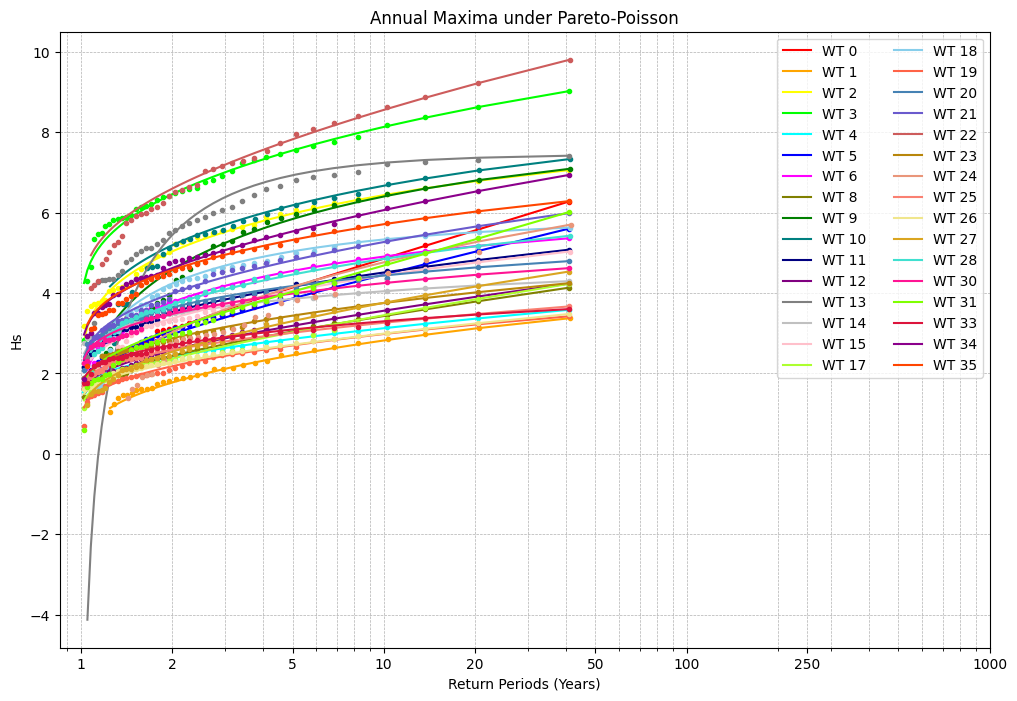

In [32]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

colors = [
    "#FF0000", "#FFA500", "#FFFF00", "#00FF00", "#00FFFF", "#0000FF", "#FF00FF", "#800000", 
    "#808000", "#008000", "#008080", "#000080", "#800080", "#808080", "#C0C0C0", "#FFC0CB", 
    "#FFD700", "#ADFF2F", "#87CEEB", "#FF6347", "#4682B4", "#6A5ACD", "#CD5C5C", "#B8860B", 
    "#E9967A", "#FA8072", "#F0E68C", "#DAA520", "#40E0D0", "#9ACD32", "#FF1493", "#7FFF00", 
    "#FF7F50", "#DC143C", "#8B008B", "#FF4500"
    ]
for wt in np.sort(unique_rwt[:-4]):
    ax.semilogx(T_ecdf_annual_maxima[wt], annual_maxima_corrected_sorted[wt], color = colors[wt], linewidth=0, marker='o',markersize=3)
    ax.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt], color = colors[wt], label=f'WT {wt}')


ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel("Hs")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.legend(ncol=2)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_title("Annual Maxima under Pareto-Poisson")
plt.savefig(f"Figuras/Hs/AnnMax_ReturnPeriod_All_Hs.png", dpi=300)
plt.show()

#### Gráficos Completos

In [33]:
folder_path = "Figuras/Hs/CompleteReturnPeriods_Hs"
os.makedirs(folder_path, exist_ok=True)


for wt in np.sort(unique_rwt[:-4]):
    
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()   

    ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
    ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
    ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

    # Si representamos los datos sin corregir
    # ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    # ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Annual Return Periods
    # Adjust the return period of corrected data (if annual maxima does not appear all the record)
    ax.semilogx(T_ecdf_annual_maxima[wt], annual_maxima_corrected_sorted[wt], color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
    ax.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt], color = "#FF0000",linestyle='dashed', label=f'Adjusted GPD-Poisson')
    
    # Confidence intervals
    ax.semilogx(T_ecdf_annual_maxima[wt], stdup[wt], color = "gray",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ecdf_annual_maxima[wt], stdlo[wt], color = "gray",linestyle='dotted')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Precipitation")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.legend(ncol=2)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_title("Annual Maxima under Pareto-Poisson")
    ax.set_ylim(-0.1, np.max(adjusted_quantiles_for_maxima[wt])+1)
    ax.set_xlim(right=11000)
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
    # plt.show()

# Serie Simulada

In [34]:
Hs_FWT_dataset = xr.open_dataset("Datos\\DatosSimulados_10000y\\FWT_Hs_sim.nc")

El tiempo va del 1 de enero del 2000 al 1 de enero del 2100, coger los datos hasta el 31 de enero del 2099

In [35]:
nsim = Hs_FWT_dataset.n_sim.values

In [36]:
Hs_simulated_data = np.array([])
year_simulated = np.array([])
month_simulated = np.array([])
day_simulated = np.array([])
wt_simulated_data = np.array([])
for i in range(len(nsim)):
    Hs_simulated_data = np.concatenate([Hs_simulated_data, Hs_FWT_dataset.Hs[i].values[:-1]])
    year_simulated = np.concatenate([year_simulated, Hs_FWT_dataset.time.values[:-1].astype('datetime64[Y]').astype(int) + 1970  + 100*i])
    month_simulated = np.concatenate([month_simulated, Hs_FWT_dataset.time.values[:-1].astype('datetime64[M]').astype(int) % 12 + 1])
    day_simulated = np.concatenate([day_simulated, (Hs_FWT_dataset.time.values[:-1].astype('datetime64[D]') - Hs_FWT_dataset.time.values[:-1].astype('datetime64[M]')).astype(int) + 1])
    wt_simulated_data = np.concatenate([wt_simulated_data, Hs_FWT_dataset.FWT[i].values[:-1]])

In [37]:
# Cambiar el indice del WT para que se asemeje a los datos historicos (rango WT0-WT35, nuevos datos rango WT1-WT36)
wt_simulated_data = wt_simulated_data -1

simulated_df = pd.DataFrame({'Hs': Hs_simulated_data,
                            'year': year_simulated,
                            'month': month_simulated,
                            'day': day_simulated,
                            'wt': wt_simulated_data})

In [39]:
# nan values
nan_values_idx = np.where(np.isnan(Hs_simulated_data))[0]
nan_values_idx

array([      2,      10,      12, ..., 3652493, 3652495, 3652497],
      dtype=int64)

In [40]:
dict_hs_sim = {}
for idx_wt, wt in enumerate(wt_range):
    dict_hs_sim[idx_wt] = simulated_df[:][simulated_df['wt'] == idx_wt]
    # dict_hs_sim[idx_wt] = dict_hs_sim[idx_wt].dropna(subset=["Hs"])
    dict_hs_sim[idx_wt]['Hs'] = dict_hs_sim[idx_wt]['Hs'].fillna(0)

In [ ]:
# Yearly maxima
hsmax_data_sim = {}
max_idx_sim = {}
max_idx_sim_40years = {}

for idx_wt, wt in enumerate(wt_range):
    hsmax_data_sim[idx_wt] = dict_hs_sim[idx_wt].groupby(["year"], as_index=False)["Hs"].max()  # Máximo anual Hs para cada WT
    max_idx_sim[idx_wt] = dict_hs_sim[idx_wt].groupby(["year"])["Hs"].idxmax().values           # Indice del máximo anual por WT
    
    max_idx_sim_40years[idx_wt] = {}
    for i_year in range(10000//40):
        max_idx_sim_40years[idx_wt][i_year] = dict_hs_sim[idx_wt][(2000+40*i_year< dict_hs_sim[idx_wt]['year']) & (dict_hs_sim[idx_wt]['year'] <= 2000+40*(i_year+1))].groupby(["year"])["Hs"].idxmax().values           # Indice del máximo anual por WT cada 40 años

In [45]:
hsmax_data_sorted_sim = {}
sorted_max_idx_sim = {}
for idx_wt, wt in enumerate(wt_range):
    hsmax_data_sorted_sim[idx_wt] = np.sort(hsmax_data_sim[idx_wt]['Hs'])
    sorted_max_idx_sim[idx_wt] = np.argsort(hsmax_data_sim[idx_wt]['Hs'])

Point-in-time simulated data

In [46]:
hspt_sim = {}
hspt_sort_sim = {}
# Hs point-in-time data per WT
for idx_wt, wt in enumerate(wt_range):
    hspt_sim[idx_wt] = dict_hs_sim[idx_wt]['Hs'].values
    hspt_sort_sim[idx_wt] = np.sort(dict_hs_sim[idx_wt]['Hs'].values)

## POTs

#### Obtendicon de los picos simulados

In [47]:
picos_sim = {}
n0 = 10
min_peak_distance = 2   # 2 días de distancia entre picos

for wt in unique_rwt[:-4]:
    # Inicializar la clase
    opt_thres_sim = OptimalThreshold(data=hspt_sim[wt])
    # Obtener los picos
    opt_thres_sim.threshold_peak_extraction(threshold=thresholds[wt],
                                            n0=n0,
                                            min_peak_distance=min_peak_distance)
    
    #picos[wt] = opt_thres.pks_unicos_valid
    picos_sim[wt] = np.sort(opt_thres_sim.pks)

In [48]:
# Datos por WT
hs_simulated_data_dict = {}
for wt in unique_rwt[:-4]:
    hs_simulated_data_dict[wt] = Hs_simulated_data[wt_simulated_data == wt]

Version lenta (sin vectorizar)

In [ ]:
"""# Defining dictionary to store all the data for differents WT
ecdf_pot_probs_sim = {}
hs_pot_wt0_corrected_sim = {}
hs_wt0_corrected_sim = {}
ecdf_pot_probs_corrected_sim ={}
T_ev_corrected_sim = {}
ecdf_pt_probs_corrected_sim = {}
T_pt_corrected_sim = {}
x_values_gpd_sim = {}
fitted_return_perd_values_gpd_sim = {}
T_pot_sim = {}
ecdf_pt_probs_wt_sim = {}
T_pt_wt_sim = {}

# Correction loop
for wt in unique_rwt[:-4]:
    # Probabilidades empíricas de los picos 
    ecdf_pot_probs_sim[wt] = np.arange(1,len(picos_sim[wt][picos_sim[wt]>thresholds[wt]])+1)/(len(picos_sim[wt][picos_sim[wt]>thresholds[wt]])+1)
    # Picos corregidos
    hs_pot_wt0_corrected_sim[wt] = qgpd(ecdf_pot_probs_sim[wt], thresholds[wt], xi[wt], sigma[wt])

    # Corrección de los datos diarios
    hs_wt0_corrected_sim[wt] = dict_hs_sim[wt]['Hs'].values.copy()
    for block_idx, max_value in enumerate(picos_sim[wt][picos_sim[wt]>thresholds[wt]]):
        if block_idx >= len(picos_sim[wt][picos_sim[wt]>thresholds[wt]])-1:
            hs_wt0_corrected_sim[wt][dict_hs_sim[wt]['Hs'].values >= picos_sim[wt][picos_sim[wt]>thresholds[wt]][-1]] = hs_pot_wt0_corrected_sim[wt][-1]
            break
        else:
            for idx, daily_value in enumerate(dict_hs_sim[wt]['Hs'].values):
                if daily_value >= picos_sim[wt][picos_sim[wt]>thresholds[wt]][block_idx] and daily_value < picos_sim[wt][picos_sim[wt]>thresholds[wt]][block_idx+1]:
                    hs_wt0_corrected_sim[wt][idx] = hs_pot_wt0_corrected_sim[wt][block_idx]+((daily_value-picos_sim[wt][picos_sim[wt]>thresholds[wt]][block_idx])/(picos_sim[wt][picos_sim[wt]>thresholds[wt]][block_idx+1]-picos_sim[wt][picos_sim[wt]>thresholds[wt]][block_idx]))*(hs_pot_wt0_corrected_sim[wt][block_idx+1]-hs_pot_wt0_corrected_sim[wt][block_idx])


    # Calculo de probabilidades y periodos de retorno
    x_values_gpd_sim[wt] = np.linspace(picos_sim[wt][picos_sim[wt] >thresholds[wt]][0], picos_sim[wt][picos_sim[wt] >thresholds[wt]][-1], 1000)
    fitted_return_perd_values_gpd_sim[wt] = 1/(1-genpareto.cdf(x_values_gpd_sim[wt], c=xi[wt], loc=thresholds[wt], scale=sigma[wt]))/poisson_parameter[wt]

    ecdf_pot_probs_corrected_sim[wt] = genpareto.cdf(qgpd(ecdf_pot_probs_sim[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), c=xi[wt], loc=thresholds[wt], scale=sigma[wt])
    T_ev_corrected_sim[wt] = 1/(1-ecdf_pot_probs_corrected_sim[wt])/poisson_parameter[wt]   # Se divide entre el nºmedio de POTs ocurrencias por WT 

    ecdf_pt_probs_corrected_sim[wt] = np.arange(1,len(hs_wt0_corrected_sim[wt])+1)/(len(hs_wt0_corrected_sim[wt])+1)
    T_pt_corrected_sim[wt] = 1/(1-ecdf_pt_probs_corrected_sim[wt])/n_return_period[wt]      # Se divide entre la probabilidad de ocurrencia de ese WT
    
    # POT sin corregir
    T_pot_sim[wt] = 1/(1-ecdf_pot_probs_sim[wt])/poisson_parameter[wt]      # Se divide entre el nºmedio de ocurrencias de ese POT por WT 

    # Daily data sin corregir
    ecdf_pt_probs_wt_sim[wt] = np.arange(1,len(dict_hs_sim[wt]['Hs'].values)+1)/(len(dict_hs_sim[wt]['Hs'].values)+1)
    T_pt_wt_sim[wt] = 1/(1-ecdf_pt_probs_wt_sim[wt])/n_return_period[wt]    # Se divide entre la probabilidad de ocurrencia de ese WT"""

C:\Users\user\AppData\Local\Temp\ipykernel_40632\2903089784.py:36: RuntimeWarning: divide by zero encountered in divide
  fitted_return_perd_values_gpd_sim[wt] = 1/(1-genpareto.cdf(x_values_gpd_sim[wt], c=xi[wt], loc=thresholds[wt], scale=sigma[wt]))/poisson_parameter[wt]


In [49]:
wt_probs_sim = simulated_df["wt"].value_counts(normalize=True).sort_index()

In [50]:
n_return_period_sim = 365.25 * wt_probs_sim

Poisson Parameter serie simulada

In [51]:
poisson_parameter_sim = {}
for i in np.sort(unique_rwt[:-4]):
    poisson_parameter_sim[i] = len(picos_sim[i])/10000

In [52]:
len(dict_hs_sim[wt]['Hs'].values[dict_hs_sim[wt]['Hs'].values > 0])

28228

In [53]:
# -- Dictionaries to store results --
ecdf_pot_probs_sim = {}
hs_pot_wt0_corrected_sim = {}
hs_wt0_corrected_sim = {}
ecdf_pot_probs_corrected_sim = {}
T_ev_corrected_sim = {}
ecdf_pt_probs_corrected_sim = {}
T_pt_corrected_sim = {}
x_values_gpd_sim = {}
fitted_return_perd_values_gpd_sim = {}
T_pot_sim = {}
ecdf_pt_probs_wt_sim = {}
T_pt_wt_sim = {}


for wt in unique_rwt[:-4]:
    # --- 1. Precompute / store repeated values in a variable ---
    peak_values = picos_sim[wt][picos_sim[wt] > thresholds[wt]]
    daily_hs = dict_hs_sim[wt]['Hs'].values[~np.isnan(dict_hs_sim[wt]['Hs'].values)]
    n_peaks = len(peak_values)
    n_daily = len(daily_hs)
    
    # --- 2. Empirical peak probabilities + GPD quantiles ---
    aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
    ecdf_pot_probs_sim[wt] = aux_ecdf_pot_probs
    # GPD-corrected peaks
    corrected_peaks = qgpd(aux_ecdf_pot_probs, thresholds[wt], xi[wt], sigma[wt])
    hs_pot_wt0_corrected_sim[wt] = corrected_peaks
    
    # --- 3. Vectorized correction of the daily data ---
    #     Only correct those daily Hs >= the first threshold peak; 
    #     below that, they remain as is. For values above the last peak, 
    #     we clamp them to the last corrected peak. Otherwise, we do a 
    #     linear interpolation between consecutive peaks.
    aux_hs_corrected = daily_hs.copy()  # copy original array
    
    if n_peaks > 1:
        # Create a boolean mask for values above the first “peak_values[0]”
        above_mask = aux_hs_corrected >= peak_values[0]
        # Clip these “above” values so that anything larger than peak_values[-1]
        # is just pinned at peak_values[-1]. This replicates your code’s logic:
        #   daily_value >= last peak => daily_value = corrected_peaks[-1].
        clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
        
        # Interpolate them onto the corrected peak range
        # By default, np.interp returns the left/right endpoint values
        # for out-of-bounds data. Since we clipped above, no extrapolation needed.
        aux_hs_corrected[above_mask] = np.interp(
            clipped_vals,         # x-coords to interpolate
            peak_values,          # x-coords of data points
            corrected_peaks       # y-coords of data points
        )
    
    hs_wt0_corrected_sim[wt] = aux_hs_corrected
    
    # --- 4. Compute probabilities & return periods ---
    #     (Same as your original code, but using local variables 
    #      to make it more readable.)

    # GPD fit over a grid of x-values
    x_vals = np.linspace(peak_values[0], peak_values[-1], 1000)
    x_values_gpd_sim[wt] = x_vals
    # Return period from GPD fit
    cdf_gpd = genpareto.cdf(x_vals, c=xi[wt], loc=thresholds[wt], scale=sigma[wt])
    fitted_return_perd_values_gpd_sim[wt] = 1.0 / (1.0 - cdf_gpd) / poisson_parameter[wt]
    
    # Corrected peaks: re-check CDF and return periods
    cdf_corrected = genpareto.cdf(
        qgpd(aux_ecdf_pot_probs, xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]),
        c=xi[wt], loc=thresholds[wt], scale=sigma[wt]
    )
    ecdf_pot_probs_corrected_sim[wt] = cdf_corrected
    T_ev_corrected_sim[wt] = 1.0 / (1.0 - cdf_corrected) / poisson_parameter[wt]
    
    # Daily corrected data
    ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_corrected_sim[wt] = ecdf_pt_probs_corrected
    T_pt_corrected_sim[wt] = 1.0 / (1.0 - ecdf_pt_probs_corrected) / n_return_period[wt] #/ poisson_parameter[wt] * poisson_parameter_sim[wt]
    
    # POT (uncorrected)
    T_pot_sim[wt] = 1.0 / (1.0 - aux_ecdf_pot_probs) / poisson_parameter[wt] 
    
    # Daily data (uncorrected)
    ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_wt_sim[wt] = ecdf_pt_probs_wt
    T_pt_wt_sim[wt] = 1.0 / (1.0 - ecdf_pt_probs_wt) / n_return_period[wt] # / poisson_parameter[wt] * poisson_parameter_sim[wt]

C:\Users\user\AppData\Local\Temp\ipykernel_3116\4049536576.py:65: RuntimeWarning: divide by zero encountered in divide
  fitted_return_perd_values_gpd_sim[wt] = 1.0 / (1.0 - cdf_gpd) / poisson_parameter[wt]


#### POTs corrected 

In [54]:
folder_path = "Figuras/Hs/SimulatedData/CorrectionPOT_WT_Hs"
os.makedirs(folder_path, exist_ok=True)


# Gráfico
for weather_type in unique_rwt[:-4]:
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()
    ax.semilogx(fitted_return_perd_values_gpd_sim[weather_type], np.sort(x_values_gpd_sim[weather_type]), color = 'orange',linestyle='dashed', label='Fitted GPD')
    ax.semilogx(T_pt_corrected_sim[weather_type], np.sort(hs_wt0_corrected_sim[weather_type]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
    ax.semilogx(T_ev_corrected_sim[weather_type], qgpd(ecdf_pot_probs_sim[weather_type], xi=xi[weather_type], threshold=thresholds[weather_type], sigma=sigma[weather_type]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($H_s$)')

    # Si representamos los datos sin corregir
    ax.semilogx(T_pot_sim[weather_type], picos_sim[weather_type][picos_sim[weather_type] > thresholds[weather_type]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    ax.semilogx(T_pt_wt_sim[weather_type], np.sort(dict_hs_sim[weather_type]['Hs'].values[~np.isnan(dict_hs_sim[weather_type]['Hs'].values)]), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Hs")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_xlim(right=10100)
    ax.legend()
    ax.grid()
    plt.savefig(f"{folder_path}/ReturnPeriod_{weather_type}.png", dpi=300)
    plt.close()
# plt.show()

#### Annual maxima corrected with Pareto-Poisson

In [ ]:
quanval=0.95

# Defining dictionaries
new_max_idx_sim = {}
annual_maxima_corrected_sim = {}
annual_maxima_corrected_sorted_sim = {}
ecdf_annual_maxima_sim = {}
T_ecdf_annual_maxima_sim = {}
adjusted_quantiles_for_maxima_sim = {}
dq_sim = {}
hessians_sim = {} 
invI0_sim = {} 
stdDq_sim = {}
stdup_sim = {}
stdlo_sim = {}

new_max_idx_sim_100 = {}
annual_maxima_corrected_sim_100 = {}
T_ecdf_annual_maxima_sim_100 = {}
ecdf_annual_maxima_sim_100 = {}


for wt in unique_rwt[:-4]:
    # Indices para los máximos corregidos
    new_max_idx_sim[wt] = dict_hs_sim[wt]['Hs'][~np.isnan(dict_hs_sim[wt]['Hs'].values)].index.get_indexer(max_idx_sim[wt])

    annual_maxima_corrected_sim[wt] = hs_wt0_corrected_sim[wt][new_max_idx_sim[wt]]
    annual_maxima_corrected_sorted_sim[wt] = np.sort(annual_maxima_corrected_sim[wt])

    # Empirical probability and Return periods for the empirical 
    ecdf_annual_maxima_sim[wt] = np.arange(1,len(annual_maxima_corrected_sorted_sim[wt])+1)/(len(annual_maxima_corrected_sorted_sim[wt])+1)
    T_ecdf_annual_maxima_sim[wt] = 1/(1-ecdf_annual_maxima_sim[wt])*(10000/len(annual_maxima_corrected_sim[wt]))   # Se divide por la proporción de años en los que aparece ese WT (nºde años que aparece / nºaños registro)
    

    # 40 by 40 years
    new_max_idx_sim_100[wt] = {}
    annual_maxima_corrected_sim_100[wt] = {}
    ecdf_annual_maxima_sim_100[wt] = {}
    T_ecdf_annual_maxima_sim_100[wt] = {}
    for i_year in range(len(new_max_idx_sim[wt])//40):
        new_max_idx_sim_100[wt][i_year] = dict_hs_sim[wt]['Hs'][~np.isnan(dict_hs_sim[wt]['Hs'].values)].index.get_indexer(max_idx_sim_40years[wt][i_year])
        annual_maxima_corrected_sim_100[wt][i_year] = hs_wt0_corrected_sim[wt][new_max_idx_sim_100[wt][i_year]]
        ecdf_annual_maxima_sim_100[wt][i_year] = np.arange(1,len(annual_maxima_corrected_sim_100[wt][i_year])+1)/(len(annual_maxima_corrected_sim_100[wt][i_year])+1)
        T_ecdf_annual_maxima_sim_100[wt][i_year] = 1/(1-ecdf_annual_maxima_sim_100[wt][i_year])*(40/len(new_max_idx_sim_100[wt][i_year]))

    # Adjusted probability
    # Usamos la probabilidad en base a los periodos de retorno por si no aparece el WT el mismo numero de años que el registro
    adjusted_quantiles_for_maxima_sim[wt] = q_pareto_poisson(1-1/(T_ecdf_annual_maxima_sim[wt]), threshold=thresholds, xi=xi, sigma=sigma, lam=poisson_parameter, wt=wt)  

    # Confidence Intervals
    dq_sim[wt] = dq_pot(ecdf_annual_maxima_sim[wt], threshold=thresholds, xi=xi, sigma=sigma, lam=poisson_parameter, wt=wt)
    _,_, hessians_sim[wt] = loglikelihood(picos_sim[wt][picos_sim[wt] > thresholds[wt]], thresholds[wt], 365.25*10000, xi, sigma, poisson_parameter, wt)
    invI0_sim[wt] = np.linalg.inv(hessians_sim[wt])
    
    stdDq_sim[wt] = np.sqrt(np.sum((dq_sim[wt].T@invI0_sim[wt]) * dq_sim[wt].T, axis=1)) # Es lo mismo 
    stdup_sim[wt] = adjusted_quantiles_for_maxima_sim[wt] + stdDq_sim[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)
    stdlo_sim[wt] = adjusted_quantiles_for_maxima_sim[wt] - stdDq_sim[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)

In [ ]:
folder_path = "Figuras/Hs/SimulatedData/CompleteReturnPeriods_Hs"
os.makedirs(folder_path, exist_ok=True)


for wt in np.sort(unique_rwt[:-4]):
    
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()   

    ax.semilogx(fitted_return_perd_values_gpd_sim[wt], np.sort(x_values_gpd_sim[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
    ax.semilogx(T_pt_corrected_sim[wt], np.sort(hs_wt0_corrected_sim[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
    ax.semilogx(T_ev_corrected_sim[wt], qgpd(ecdf_pot_probs_sim[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

    # Si representamos los datos sin corregir
    # ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    # ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Annual Return Periods
    # Adjust the return period of corrected data (if annual maxima does not appear all the record)
    ax.semilogx(T_ecdf_annual_maxima_sim[wt], annual_maxima_corrected_sorted_sim[wt], color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
    ax.semilogx(T_ecdf_annual_maxima_sim[wt], adjusted_quantiles_for_maxima_sim[wt], color = "#FF0000",linestyle='dashed', label=f'Adjusted GPD-Poisson')
    
    # Confidence intervals
    ax.semilogx(T_ecdf_annual_maxima_sim[wt], stdup_sim[wt], color = "gray",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ecdf_annual_maxima_sim[wt], stdlo_sim[wt], color = "gray",linestyle='dotted')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Precipitation")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.legend(ncol=2)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_title("Annual Maxima under Pareto-Poisson")
    ax.set_ylim(-0.1, np.max(adjusted_quantiles_for_maxima[wt])+1)
    ax.set_xlim(right=11000)
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
    # plt.show()

#### Weather Type 0

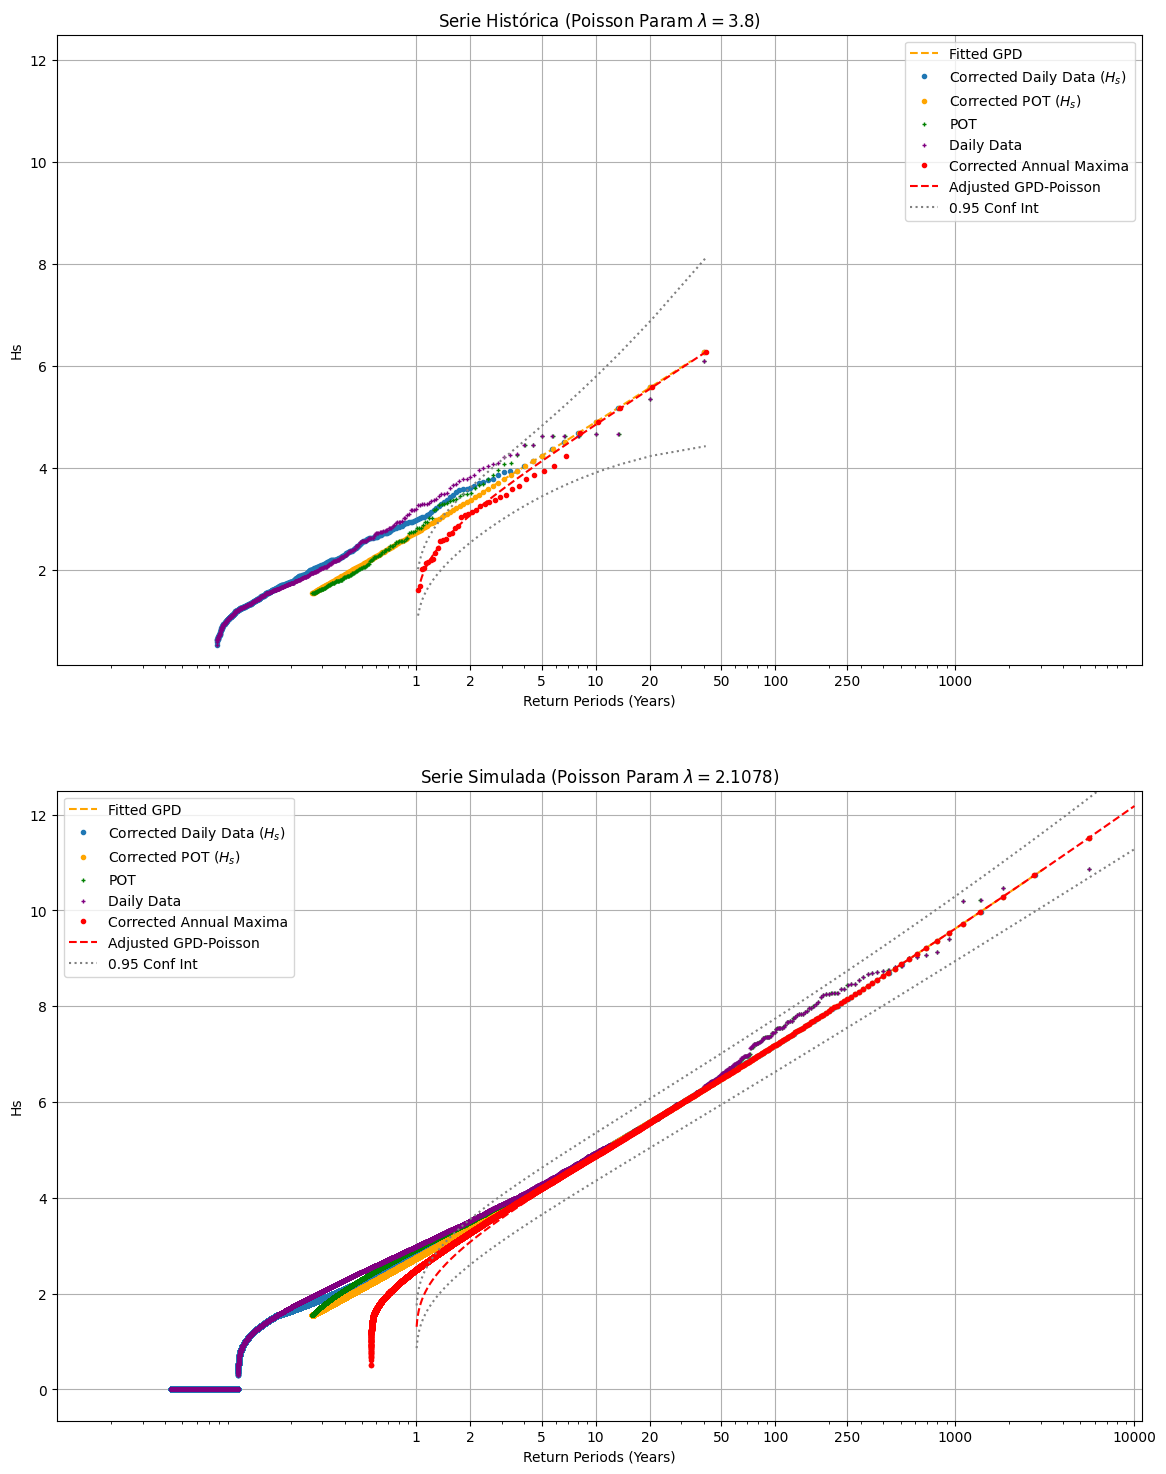

In [56]:
fig = plt.figure(figsize=(14,18))

# Weather type
wt = 0

# Serie histórica
ax1 = fig.add_subplot(211)
ax1.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Fitted GPD')
ax1.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
ax1.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($H_s$)')

# Si representamos los datos sin corregir
ax1.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
ax1.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

# Annual Maxima
ax1.semilogx(T_ecdf_annual_maxima[wt], annual_maxima_corrected_sorted[wt], color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
ax1.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt], color = "#FF0000",linestyle='dashed', label=f'Adjusted GPD-Poisson')
# Confidence intervals
ax1.semilogx(T_ecdf_annual_maxima[wt], stdup[wt], color = "gray",linestyle='dotted', label=f'{quanval} Conf Int')
ax1.semilogx(T_ecdf_annual_maxima[wt], stdlo[wt], color = "gray",linestyle='dotted')


ax1.set_xlabel("Return Periods (Years)")
ax1.set_ylabel("Hs")
ax1.set_xscale('log')
ax1.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax1.set_xlim(left=0.01, right=11000)
ax1.set_ylim(top=12.5)
ax1.legend()
ax1.grid()
ax1.set_title(fr"Serie Histórica (Poisson Param $\lambda={poisson_parameter[wt]}$)")

# Serie simulada
ax2 = fig.add_subplot(212)
ax2.semilogx(fitted_return_perd_values_gpd_sim[wt], np.sort(x_values_gpd_sim[wt]), color = 'orange',linestyle='dashed', label='Fitted GPD')
ax2.semilogx(T_pt_corrected_sim[wt]*poisson_parameter_sim[wt]/poisson_parameter[wt], np.sort(hs_wt0_corrected_sim[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
ax2.semilogx(T_ev_corrected_sim[wt], qgpd(ecdf_pot_probs_sim[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($H_s$)')

# Si representamos los datos sin corregir
ax2.semilogx(T_pot_sim[wt], picos_sim[wt][picos_sim[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
ax2.semilogx(T_pt_wt_sim[wt]*poisson_parameter_sim[wt]/poisson_parameter[wt], np.sort(dict_hs_sim[wt]['Hs'].values[~np.isnan(dict_hs_sim[wt]['Hs'].values)]), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

# Annual maxima
ax2.semilogx(T_ecdf_annual_maxima_sim[wt]*poisson_parameter_sim[wt]/poisson_parameter[wt], annual_maxima_corrected_sorted_sim[wt], color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
ax2.semilogx(T_ecdf_annual_maxima_sim[wt], adjusted_quantiles_for_maxima_sim[wt], color = "#FF0000",linestyle='dashed', label=f'Adjusted GPD-Poisson')

# Confidence intervals
ax2.semilogx(T_ecdf_annual_maxima_sim[wt], stdup_sim[wt], color = "gray",linestyle='dotted', label=f'{quanval} Conf Int')
ax2.semilogx(T_ecdf_annual_maxima_sim[wt], stdlo_sim[wt], color = "gray",linestyle='dotted')

# DATOS HISTORICOS
# ax2.semilogx(T_ev_corrected_sim[wt]*poisson_parameter_sim[wt]/poisson_parameter[wt], qgpd(ecdf_pot_probs_sim[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='+',markersize=3, label=r'Corrected POT ($H_s$)')
# ax2.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), linestyle='dashdot', label='Historical Fitted GPD')  # POT
# ax2.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt],linestyle='dashdot', label=f'Historical Adjusted GPD-Poisson')  # Annual max
# # Confidence intervals
# ax2.semilogx(T_ecdf_annual_maxima[wt], stdup[wt], color = "gray",linestyle='dashdot', label=f'{quanval} Historical Conf Int')
# ax2.semilogx(T_ecdf_annual_maxima[wt], stdlo[wt], color = "gray",linestyle='dashdot')

ax2.set_xlabel("Return Periods (Years)")
ax2.set_ylabel("Hs")
ax2.set_xscale('log')
ax2.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax2.set_xlim(left=0.01, right=11000)
ax2.set_ylim(top=12.5)
ax2.legend()
ax2.grid()
ax2.set_title(fr"Serie Simulada (Poisson Param $\lambda={poisson_parameter_sim[wt]}$)")


plt.show()

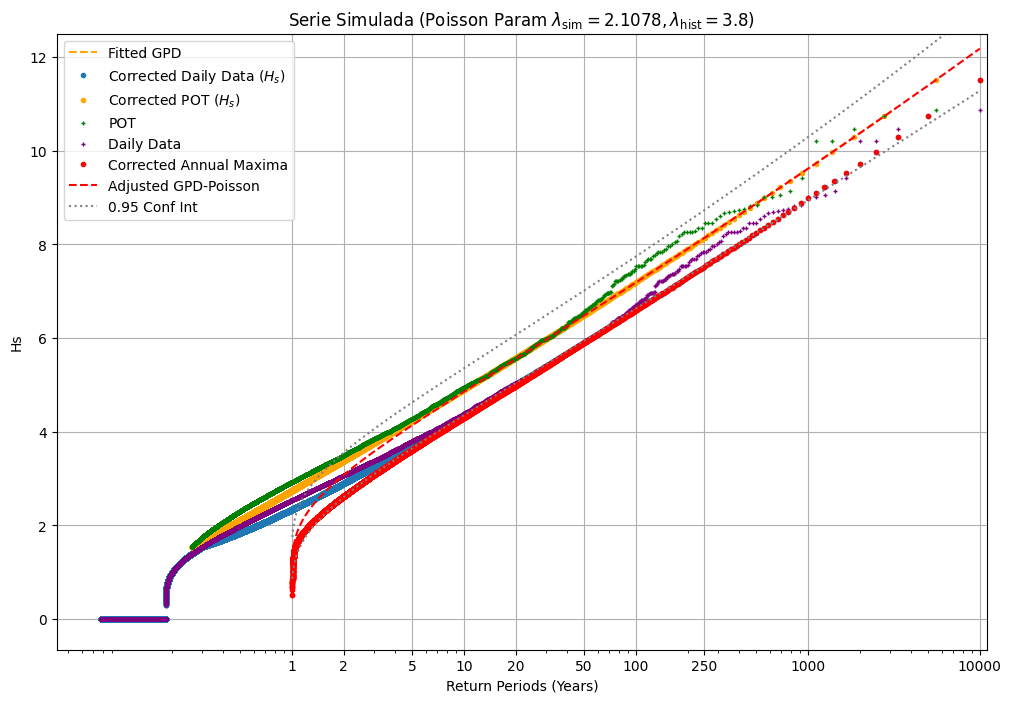

In [58]:
wt = 0

fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(111)
ax2.semilogx(fitted_return_perd_values_gpd_sim[wt], np.sort(x_values_gpd_sim[wt]), color = 'orange',linestyle='dashed', label='Fitted GPD')
ax2.semilogx(T_pt_corrected_sim[wt], np.sort(hs_wt0_corrected_sim[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
ax2.semilogx(T_ev_corrected_sim[wt], qgpd(ecdf_pot_probs_sim[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($H_s$)')

# Si representamos los datos sin corregir
ax2.semilogx(T_pot_sim[wt], picos_sim[wt][picos_sim[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
ax2.semilogx(T_pt_wt_sim[wt], np.sort(dict_hs_sim[wt]['Hs'].values[~np.isnan(dict_hs_sim[wt]['Hs'].values)]), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

# Annual maxima
ax2.semilogx(T_ecdf_annual_maxima_sim[wt], annual_maxima_corrected_sorted_sim[wt], color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
ax2.semilogx(T_ecdf_annual_maxima_sim[wt], adjusted_quantiles_for_maxima_sim[wt], color = "#FF0000",linestyle='dashed', label=f'Adjusted GPD-Poisson')

# Confidence intervals
ax2.semilogx(T_ecdf_annual_maxima_sim[wt], stdup_sim[wt], color = "gray",linestyle='dotted', label=f'{quanval} Conf Int')
ax2.semilogx(T_ecdf_annual_maxima_sim[wt], stdlo_sim[wt], color = "gray",linestyle='dotted')

# DATOS HISTORICOS
# ax2.semilogx(T_ev_corrected_sim[wt]*poisson_parameter_sim[wt]/poisson_parameter[wt], qgpd(ecdf_pot_probs_sim[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='+',markersize=3, label=r'Corrected POT ($H_s$)')
# ax2.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), linestyle='dashdot', label='Historical Fitted GPD')  # POT
# ax2.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt],linestyle='dashdot', label=f'Historical Adjusted GPD-Poisson')  # Annual max
# # Confidence intervals
# ax2.semilogx(T_ecdf_annual_maxima[wt], stdup[wt], color = "gray",linestyle='dashdot', label=f'{quanval} Historical Conf Int')
# ax2.semilogx(T_ecdf_annual_maxima[wt], stdlo[wt], color = "gray",linestyle='dashdot')

ax2.set_xlabel("Return Periods (Years)")
ax2.set_ylabel("Hs")
ax2.set_xscale('log')
ax2.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax2.set_xlim(right=11000)
ax2.set_ylim(top=12.5)
ax2.legend()
ax2.grid()
ax2.set_title(fr"Serie Simulada (Poisson Param $\lambda_{{\text{{sim}}}}={poisson_parameter_sim[wt]}, \lambda_{{\text{{hist}}}}={poisson_parameter[wt]}$)")


plt.show()

#### Serie historica con bandas de confianza y datos simulados de 100 en 100 años

In [738]:
folder_path = "Figuras/Hs/SimulatedData/HistoricalData_100ySimulated"
os.makedirs(folder_path, exist_ok=True)


for wt in np.sort(unique_rwt[:-4]):
    
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()   

    # ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
    # ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
    # ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

    # Si representamos los datos sin corregir
    # ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    # ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Serie simulada 40 por 40 años
    ax.semilogx(T_ecdf_annual_maxima_sim_100[wt][0]/poisson_parameter[wt]*poisson_parameter_sim[wt], np.sort(annual_maxima_corrected_sim_100[wt][0]), color = "gray", alpha = 0.1, label="Simulated Data Divided by 40 Years")
    for i_year in range(1,len(new_max_idx_sim[wt])//40):
        ax.semilogx(T_ecdf_annual_maxima_sim_100[wt][i_year]/poisson_parameter[wt]*poisson_parameter_sim[wt], np.sort(annual_maxima_corrected_sim_100[wt][i_year]), color = "gray", alpha = 0.1)

    # Annual Return Periods
    # Adjust the return period of corrected data (if annual maxima does not appear all the record)
    ax.semilogx(T_ecdf_annual_maxima[wt], annual_maxima_corrected_sorted[wt], color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
    ax.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt], color = "#FF0000",linestyle='dashed', label=f'Adjusted GPD-Poisson')
    
    # Confidence intervals
    ax.semilogx(T_ecdf_annual_maxima[wt], stdup[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ecdf_annual_maxima[wt], stdlo[wt], color = "black",linestyle='dotted')
    
    

    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Precipitation")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.legend(ncol=2)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_title("Annual Maxima under Pareto-Poisson")
    ax.set_ylim(-0.1, np.max(adjusted_quantiles_for_maxima[wt])+1)
    ax.set_xlim(right=1000)
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
    # plt.show()

## Annual Maxima

Corrección de la serie simulada teniendo en cuenta como extremos los Máximos Anuales. Esta corrección sigue los siguientes pasos:

- Paso 1: Calculo de los máximos anuales históricos para cada WT
- Paso 2: Ajuste de la GEV para los Máximos Anuales históricos para cada WT
- Paso 3: Corrección de los datos históricos para cada WT
- Paso 4: Corrección de los datos Simulados para cada WT

Aparte de estos pasos, una vez hecha la corrección hay distintos subapartados que incluyen los gráficos de los periodos de retorno de los máximos corregidos.

### Paso 1: Calculo de los máximos anuales históricos para cada WT

In [98]:
# dict_hs contains the data associated to each WT

# Dictionaries
max_data_hist = {}
max_idx_hist = {}
max_data_hist_sort = {}
max_idx_hist_sort = {}

# Obtaining annual maxima and indices associated
for wt in unique_rwt[:]:
    max_data_hist[wt] = dict_hs[wt].groupby(["yyyy"], as_index=False)["Hs"].max()["Hs"].values
    max_idx_hist[wt] = dict_hs[wt].groupby(["yyyy"])["Hs"].idxmax().values
    max_data_hist_sort[wt] = np.sort(max_data_hist[wt])
    max_idx_hist_sort[wt] = np.argsort(max_data_hist[wt])

### Paso 2: Ajuste de la GEV para los Máximos Anuales históricos

Cuidado con esto, al usar `stats.genextreme` el parámetro de forma tiene el signo contrario al usual.

In [72]:
shape_gev = {}
loc_gev = {}
scale_gev = {}

for wt in unique_rwt[:]:
    shape_gev[wt], loc_gev[wt], scale_gev[wt] = stats.genextreme.fit(max_data_hist[wt])

#### QQ plots

In [ ]:
folder_path = "Figuras/Hs/AnnualMax/QQplots"
os.makedirs(folder_path, exist_ok=True)

for wt in unique_rwt[:]:
    # Calcular cuantiles teóricos de la GPD ajustada
    n = len(max_data_hist[wt])
    probabilities = (np.arange(1, n + 1)) / (n+1)  # Probabilidades de los cuantiles empíricos
    gev_quantiles = stats.genextreme.ppf(probabilities, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])

    # Ordenar los datos observados para comparación con los cuantiles teóricos
    sorted_data = np.sort(max_data_hist[wt])

    # Crear el QQ-plot
    plt.figure(figsize=(7, 7))
    plt.scatter(gev_quantiles, sorted_data, label="Datos vs. GEV", alpha=0.7)
    plt.plot(gev_quantiles, gev_quantiles, 'r--', label="y = x (Referencia)")

    # Etiquetas
    plt.xlabel("Cuantiles Teóricos (GEV ajustada)")
    plt.ylabel("Cuantiles Empíricos (Datos)")
    # plt.title("QQ-plot: Ajuste de la GEV a los Datos")
    plt.legend()
    plt.grid()
    plt.savefig(f"{folder_path}/QQPlot_WT{wt}.png", dpi=200)
    plt.close()

### Paso 3: Corrección Extremal de los datos históricos

Definición de la función negativa de verosimilitud y derivada de la función cuantil para la GEV estacionaria (util para calcular la hessiana y los intervalos de confianza de la GEV)

Funciones antiguas (MAL PARA LA ESTACIONARIA):

In [ ]:
# def dq_gev(probs, xi, loc, sigma, wt, quanval):
#     """
#     Calculates the dertivative of quantiles of POT
#     """
#     nd = len(probs)

#     # Parámetro de localización es un escalar
#     loct = loc[wt] * np.ones_like(probs)
#     # Escala: se calcula a partir de exp(p[1]) y se extiende a todos los datos
#     sigt = sigma[wt] * np.ones_like(probs)
    
#     # Parámetro de forma: si p tiene 3 elementos se utiliza, sino se asume cero
#     if np.abs(xi[wt]) > 1e-8:
#         neps0 = 1
#         epst = -xi[wt] * np.ones_like(probs)
#     else:
#         neps0 = 0
#         epst = np.zeros_like(probs)

#     # Se determinan los índices donde el parámetro de forma es prácticamente cero (caso Gumbel)
#     posG = np.where(np.abs(epst) <= 1e-8)[0]
#     pos  = np.where(np.abs(epst) > 1e-8)[0]

#     loct[pos] = loct[pos]+sigt[pos]*(np.ones_like(probs)[pos]**epst[pos]-1)/epst[pos]
#     sigt[pos] = sigt[pos]*np.ones_like(probs)[pos]**epst[pos]
#     # Modify the parameters to include the length of the data in Gumbel
#     loct[posG] = loct[posG] + sigt[posG]*np.log(np.ones_like(probs)[posG])

#     Dqmut = np.zeros(nd)
#     Dqpsit = np.zeros(nd)
#     Dqepst = np.zeros(nd)
    
#     # Derivatives of the quantile function with respect to location, scale and shape parameters
#     Dqmut[pos] = np.ones_like(loct[pos])
#     Dqpsit[pos] = -(1-(-np.log(1-quanval)/np.ones_like(probs)[pos])**(-epst[pos]))/epst[pos]
#     Dqepst[pos] = sigt[pos]*(1-(-np.log(1-quanval)/np.ones_like(probs)[pos])**(-epst[pos])*(1+epst[pos]*np.log(-np.log(1-quanval)/np.ones_like(probs)[pos])))/(epst[pos]*epst[pos])

#     # Gumbel derivatives
#     Dqmut[posG] = np.ones_like(loct[posG])
#     Dqpsit[posG] = -np.log(-np.log(1-quanval)/np.ones_like(probs)[posG])
#     Dqepst[posG] = np.zeros_like(loct[posG])
    
#     ## New Derivatives
#     Dmutastmut = np.ones_like(probs)
#     Dmutastpsit = (-1 + np.ones_like(probs) ** epst) / epst
#     Dmutastepst = sigt * (1 + (np.ones_like(probs) ** epst) * (epst * np.log(np.ones_like(probs)) - 1)) / (epst ** 2)

#     Dpsitastpsit = np.ones_like(probs) ** epst
#     Dpsitastepst = np.log(np.ones_like(probs)) * sigt * (np.ones_like(probs) ** epst)

#     Dmutastpsit[posG] = np.log(np.ones_like(probs)[posG])
#     Dmutastepst[posG] = 0

#     Dpsitastpsit[posG] = 1
#     Dpsitastepst[posG] = 0

#     Dq = np.zeros((3,len(probs)))

#     Dq[0,:] = Dqmut*Dmutastmut  # beta0
#     Dq[1,:] = sigt*(Dqpsit*Dpsitastpsit+Dqmut*Dmutastpsit)  # alpha0
#     Dq[2,:] = Dqepst+Dqpsit*Dpsitastepst+Dqmut*Dmutastepst  # gamma0

#     return Dq


# def loglikelihood_gev(x, xi, loc, sigma, wt):
#     """
#     Calcula el log-likelihood, su gradiente (Jacobian) y la matriz Hessiana
#     para la distribucion GEV estacionaria.

#     Parámetros:
#       x     : datos (vector numpy).
#       Ts    : total (por ejemplo, tiempo total o número de días) para el componente Poisson.
#       xi    : -shape parameter
#       loc   : location parameter
#       sigma : scale parameter

#     Retorna:
#       f   : valor del log-likelihood (negativo de la función objetivo)
#       Jx  : gradiente (vector de tamaño 2 o 3, dependiendo de p)
#       Hxx : Hessiana (matriz de tamaño 2x2 o 3x3)
#     """
#     N = len(x)
    
#     # Parámetro de localización es un escalar
#     loct = loc[wt] * np.ones_like(x)
#     # Escala: se calcula a partir de exp(p[1]) y se extiende a todos los datos
#     sigt = sigma[wt] * np.ones_like(x)
    
#     # Parámetro de forma: si p tiene 3 elementos se utiliza, sino se asume cero
#     if np.abs(xi[wt]) > 1e-8:
#         neps0 = 1
#         epst = -xi[wt] * np.ones_like(x)
#     else:
#         neps0 = 0
#         epst = np.zeros_like(x)

#     # Se determinan los índices donde el parámetro de forma es prácticamente cero (caso Gumbel)
#     posG = np.where(np.abs(epst) <= 1e-8)[0]
#     pos  = np.where(np.abs(epst) > 1e-8)[0]

#     loct[pos] = loct[pos]+sigt[pos]*(np.ones_like(x)[pos]**epst[pos]-1)/epst[pos]
#     sigt[pos] = sigt[pos]*np.ones_like(x)[pos]**epst[pos]
#     # Modify the parameters to include the length of the data in Gumbel
#     loct[posG] = loct[posG] + sigt[posG]*np.log(np.ones_like(x)[posG])

#     # Evaluate auxiliarly variables
#     xn = (x-loct)/sigt
#     z = 1+epst*xn

#     # Since z-values must be greater than 0 in order to avoid numerical problems, their values are set to be greater than 1e-8
#     z = np.maximum(1e-8, z)
#     zn = z**(-1/epst)

#     # Evaluate the loglikelihood function, not that the general and Gumbel expressions are used
#     f = - np.sum(-np.log(np.ones_like(x)[pos]) + np.log(sigt[pos]) + (1+1/epst[pos])*np.log(z[pos])+np.ones_like(x)[pos]*zn[pos]) - \
#         np.sum(-np.log(np.ones_like(x)[posG]) + np.log(sigt[posG]) + xn[posG] + np.ones_like(x)[posG]*np.exp(-xn[posG]))
        
    
#     ### Gradient of the loglikelihood
#     # Derivatives given by equations (A.1)-(A.3) in the paper
#     Dmut = (1+epst-np.ones_like(x)*zn) / (sigt*z)
#     Dpsit = -(1-xn*(1-np.ones_like(x)*zn)) / (sigt*z)
#     Depst = zn * (xn*(np.ones_like(x)-(1+epst)/zn)+z*(-np.ones_like(x)+1/zn)*np.log(z)/epst) / (epst*z)

#     # Gumbel derivatives given by equations (A.4)-(A.5) in the paper
#     Dmut[posG] = (1-np.ones_like(x)[posG]*np.exp(-xn[posG])) / sigt[posG]
#     Dpsit[posG] = (xn[posG]-1-np.ones_like(x)[posG]*xn[posG]*np.exp(-xn[posG])) / (sigt[posG])
#     Depst[posG] = 0


#     ## New Derivatives
#     Dmutastmut = np.ones_like(x)
#     Dmutastpsit = (-1 + np.ones_like(x) ** epst) / epst
#     Dmutastepst = sigt * (1 + (np.ones_like(x) ** epst) * (epst * np.log(np.ones_like(x)) - 1)) / (epst ** 2)

#     Dpsitastpsit = np.ones_like(x) ** epst
#     Dpsitastepst = np.log(np.ones_like(x)) * sigt * (np.ones_like(x) ** epst)

#     Dmutastpsit[posG] = np.log(np.ones_like(x)[posG])
#     Dmutastepst[posG] = 0

#     Dpsitastpsit[posG] = 1
#     Dpsitastepst[posG] = 0

#     # Set the Jacobian to zero
#     Jx = np.zeros(2 + neps0)
#     # Jacobian elements related to the location parameters beta0 and beta, equation (A.6) in the paper
#     Jx[0] = np.dot(Dmut,Dmutastmut) # loc
#     Jx[1] = np.sum(sigt*(Dpsit*Dpsitastpsit+Dmut*Dmutastpsit))  # scale
#     # Jacobian elements related to the shape parameters gamma0 and gamma (equation A.10)
#     if neps0 == 1:
#         Jx[2] = np.sum(Depst+Dpsit*Dpsitastepst+Dmut*Dmutastepst)

#     ### Hessian matrix
#     # Derivatives given by equations (A.13)-(A.17) in the paper
#     D2mut = (1+epst)*zn*(-1+epst*z**(1/epst))/((z*sigt)**2)
#     D2psit = (-zn*xn*((1-epst)*xn-2)+((1-2*xn)-epst*(xn**2)))/((z*sigt)**2)
#     D2epst = -zn*(xn*(xn*(1+3*epst)+2+(-2-epst*(3+epst)*xn)*z**(1/epst)) + (z/(epst*epst))*np.log(z)*(2*epst*(-xn*(1+epst)-1+z**(1+1/epst))+z*np.log(z)))/(epst*epst*z**2)
#     Dmutpsit = -(1+epst-(1-xn)*zn)/((z*sigt)**2)
#     Dmutepst = -zn*(epst*(-(1+epst)*xn-epst*(1-xn)*z**(1/epst))+z*np.log(z))/(epst*epst*sigt*z**2)
#     Dpsitepst = xn*Dmutepst

#     # Corresponding Gumbel derivatives given by equations (A.18)-(A.20)
#     D2mut[posG] = -(np.exp(-xn[posG])) / (sigt[posG] ** 2)
#     D2psit[posG] = ((1 - 2 * xn[posG]) + np.exp(-xn[posG]) * (2 - xn[posG]) * xn[posG]) / (sigt[posG] ** 2)
#     D2epst[posG] = 0  
#     Dmutpsit[posG] = (-1 + np.exp(-xn[posG]) * (1 - xn[posG])) / (sigt[posG] ** 2)
#     Dmutepst[posG] = 0  
#     Dpsitepst[posG] = 0

#     # Initialize the Hessian matrix
#     Hxx = np.zeros((2 + neps0, 2 + neps0))
#     # Elements of the Hessian matrix
#     ## DIAGONAL SUB-BLOCKS
#     # Sub-block number 1, beta0^2
#     Hxx[0,0] = np.sum(D2mut)
#     # Sub-block number 8 (Scale exponential involved), beta0*alpha0
#     Hxx[1, 0] = np.sum(Dmutpsit*sigt)
#     # Sub-block number 6, alpha0^2
#     Hxx[1,1] = np.sum((D2psit*sigt+Dpsit)*sigt)
#     if neps0 == 1:
#         # Sub-block number 7, gamma0^2
#         Hxx[2, 2] = np.sum(D2epst)
#         # Sub-block number 9, beta0*gamma0
#         Hxx[2,0] = np.sum(Dmutepst)
#         # Sub-block number 10 (Scale exponential involved), alpha0*gamma0
#         Hxx[2, 1] = np.sum(Dpsitepst*sigt)
    
#     # Se completa la simetrización (se suma la parte triangular inferior transpuesta)
#     Hxx = Hxx + np.tril(Hxx, -1).T
#     Hxx = -Hxx  # se retorna el negativo
    
#     return f, Jx, Hxx


Funciones nuevas:

In [ ]:
def nll(data, p):
    """
    Usefull to compute the variance-covariance matrix using the hessian from numdifftools
    """
    xi = -p[2]
    mu = p[0]
    sigma = p[1]
    
    # Gumbel 
    if np.abs(xi) < 1e-8:
        expr = (data-mu)/sigma
        return (len(data)*np.log(sigma) + np.sum(expr) + np.sum(np.exp(-expr)))

    # Weibull-Frechet 
    else:
        expr = 1+xi*((data-mu)/sigma)
        return (len(data)*np.log(sigma) + (1+1/xi)*np.sum(np.log(expr)) + np.sum(expr **(-1/xi)))

def dq_gev_nuevo(prob,p):
    """
    Quantile derivatives 
    """
    xi = -p[2]
    mu = p[0]
    sigma = p[1]

    if np.abs(xi) < 1e-8:
        dmu = 1*np.ones_like(prob)
        dsigma = -np.log(-np.log(prob))
        dxi = np.zeros_like(prob)
    else:
        dmu = 1*np.ones_like(prob)
        dsigma = ((-np.log(prob))**(-xi)-1)/xi
        dxi = -(sigma*(np.log(-np.log(prob))*xi - (-np.log(prob))**xi +1))/(((-np.log(prob))**xi) * xi **2)

    Dq = np.zeros((3,len(prob)))

    Dq[0,:] = dmu
    Dq[1,:] = dsigma
    Dq[2,:] = dxi

    return Dq
    

In [ ]:
# -- Dictionaries to store results --
ecdf_annmax_probs_hist = {}
hs_annmax_corrected_hist= {}
hs_corrected_hist = {}
ecdf_annmax_probs_corrected_hist = {}
T_ev_corrected_hist = {}
ecdf_pt_probs_corrected_hist = {}
T_pt_corrected_hist = {}
x_values_gev_hist = {}
fitted_return_perd_values_gev_hist = {}
T_pot_hist = {}
ecdf_pt_probs_wt_hist = {}
T_pt_wt_hist = {}


quanval = 0.95
dqgev = {}
hessians_gev = {} 
invI0_gev = {} 
stdDq_gev = {}
stdup_gev = {}
stdlo_gev = {}


for wt in unique_rwt[:-4]:
    # --- 1. Precompute / store repeated values in a variable ---
    peak_values = max_data_hist_sort[wt]
    daily_hs = dict_hs[wt]['Hs'].values
    n_peaks = len(peak_values)
    n_daily = len(daily_hs)
    
    # --- 2. Empirical peak probabilities + GEV quantiles ---
    aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
    ecdf_annmax_probs_hist[wt] = aux_ecdf_pot_probs
    # GPD-corrected peaks
    corrected_peaks = stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])
    hs_annmax_corrected_hist[wt] = corrected_peaks
    
    # --- 3. Vectorized correction of the daily data ---
    #     Only correct those daily Hs >= the first threshold peak; 
    #     below that, they remain as is. For values above the last peak, 
    #     we clamp them to the last corrected peak. Otherwise, we do a 
    #     linear interpolation between consecutive peaks.
    aux_hs_corrected = daily_hs.copy()  # copy original array
    
    if n_peaks > 1:
        # Create a boolean mask for values above the first “peak_values[0]”
        above_mask = aux_hs_corrected > peak_values[0]
        # Clip these “above” values so that anything larger than peak_values[-1]
        # is just pinned at peak_values[-1]. This replicates your code’s logic:
        #   daily_value >= last peak => daily_value = corrected_peaks[-1].
        clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
        
        # Interpolate them onto the corrected peak range
        # By default, np.interp returns the left/right endpoint values
        # for out-of-bounds data. Since we clipped above, no extrapolation needed.
        aux_hs_corrected[above_mask] = np.interp(
            clipped_vals,         # x-coords to interpolate
            peak_values,          # x-coords of data points
            corrected_peaks       # y-coords of data points
        )
    
    hs_corrected_hist[wt] = aux_hs_corrected
    
    # --- 4. Compute probabilities & return periods ---
    #     (Same as your original code, but using local variables 
    #      to make it more readable.)

    # GPD fit over a grid of x-values
    x_vals = np.linspace(corrected_peaks[0], corrected_peaks[-1], 1000)
    x_values_gev_hist[wt] = x_vals
    # Return period from GPD fit
    cdf_gev = stats.genextreme.cdf(x_vals, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])
    fitted_return_perd_values_gev_hist[wt] = 1.0 / (1.0 - cdf_gev) *(40/n_peaks)
    
    # Corrected peaks: re-check CDF and return periods
    cdf_corrected = stats.genextreme.cdf(
        stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]),
        shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]
    )
    ecdf_annmax_probs_corrected_hist[wt] = cdf_corrected
    T_ev_corrected_hist[wt] = 1.0 / (1.0 - cdf_corrected) *(40/n_peaks)
    
    # Daily corrected data
    ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_corrected_hist[wt] = ecdf_pt_probs_corrected
    T_pt_corrected_hist[wt] = 1.0 / (1.0 - ecdf_pt_probs_corrected) / n_return_period[wt] 
    
    # POT (uncorrected)
    T_pot_hist[wt] = 1.0 / (1.0 - aux_ecdf_pot_probs) *(40/n_peaks)
    
    # Daily data (uncorrected)
    ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_wt_hist[wt] = ecdf_pt_probs_wt
    T_pt_wt_hist[wt] = 1.0 / (1.0 - ecdf_pt_probs_wt) / n_return_period[wt]

    # Confidence intervals
    # dqgev[wt] = dq_gev(ecdf_annmax_probs_hist[wt], xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt, quanval=quanval)
    dqgev[wt] = dq_gev_nuevo(ecdf_annmax_probs_hist[wt], p=[loc_gev[wt], scale_gev[wt], shape_gev[wt]])
    # _,_,hessians_gev[wt] = loglikelihood_gev(peak_values, xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt)
    aux_fun = lambda x: nll(max_data_hist[wt], x)
    hess = ndt.Hessian(aux_fun)
    hessians_gev[wt] = hess([loc_gev[wt], scale_gev[wt], shape_gev[wt]])
    invI0_gev[wt] = np.linalg.inv(hessians_gev[wt])

    stdDq_gev[wt] = np.sqrt(np.sum((dqgev[wt].T@invI0_gev[wt]) * dqgev[wt].T, axis=1)) # Es lo mismo 
    stdup_gev[wt] = hs_annmax_corrected_hist[wt] + stdDq_gev[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)
    stdlo_gev[wt] = hs_annmax_corrected_hist[wt] - stdDq_gev[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)

Maximos anuales sin corregir y GEV ajustada

In [310]:
folder_path = "Figuras/Hs/AnnualMax/CorrectionAnn_WT_Hs_EmpiricalData"
os.makedirs(folder_path, exist_ok=True)


# Gráfico
for wt in unique_rwt[:-4]:
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()
    ax.semilogx(fitted_return_perd_values_gev_hist[wt], np.sort(x_values_gev_hist[wt]), color = 'orange',linestyle='dashed', label='Fitted GEV')
    # ax.semilogx(T_pt_corrected_hist[wt], np.sort(hs_corrected_hist[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
    # ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima ($H_s$)')

    # Si representamos los datos sin corregir
    ax.semilogx(T_pot_hist[wt], max_data_hist_sort[wt], color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')
    ax.semilogx(T_pt_wt_hist[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')


    # Confidence interval for fitted GEV
    ax.semilogx(T_ev_corrected_hist[wt], stdup_gev[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ev_corrected_hist[wt], stdlo_gev[wt], color = "black",linestyle='dotted')

    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Hs")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_xlim(right=250)
    ax.legend()
    ax.grid()
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
# plt.show()

### Paso 4: Corrección de los datos **Simulados** para cada WT

In [289]:
# -- Dictionaries to store results --
ecdf_annmax_probs_sim = {}
hs_annmax_corrected_sim= {}
hs_corrected_sim = {}
ecdf_annmax_probs_corrected_sim = {}
T_ev_corrected_sim = {}
ecdf_pt_probs_corrected_sim = {}
T_pt_corrected_sim = {}
x_values_gev_sim = {}
fitted_return_perd_values_gev_sim = {}
T_pot_sim = {}
ecdf_pt_probs_wt_sim= {}
T_pt_wt_sim= {}

quanval = 0.95
dqgev_sim = {}
hessians_gev_sim = {} 
invI0_gev_sim = {} 
stdDq_gev_sim = {}
stdup_gev_sim = {}
stdlo_gev_sim = {}

for wt in unique_rwt[:-4]:
    # --- 1. Precompute / store repeated values in a variable ---
    peak_values = np.sort(hsmax_data_sim[wt]['Hs'].values)
    daily_hs = dict_hs_sim[wt]['Hs'].values
    n_peaks = len(peak_values)
    n_daily = len(daily_hs)
    
    # --- 2. Empirical peak probabilities + GEV quantiles ---
    aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
    ecdf_annmax_probs_sim[wt] = aux_ecdf_pot_probs
    # GPD-corrected peaks
    corrected_peaks = stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])
    hs_annmax_corrected_sim[wt] = corrected_peaks
    
    # --- 3. Vectorized correction of the daily data ---
    #     Only correct those daily Hs >= the first threshold peak; 
    #     below that, they remain as is. For values above the last peak, 
    #     we clamp them to the last corrected peak. Otherwise, we do a 
    #     linear interpolation between consecutive peaks.
    aux_hs_corrected = daily_hs.copy()  # copy original array
    
    if n_peaks > 1:
        # Create a boolean mask for values above the first “peak_values[0]”
        above_mask = aux_hs_corrected > peak_values[0]
        # Clip these “above” values so that anything larger than peak_values[-1]
        # is just pinned at peak_values[-1]. This replicates your code’s logic:
        #   daily_value >= last peak => daily_value = corrected_peaks[-1].
        clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
        
        # Interpolate them onto the corrected peak range
        # By default, np.interp returns the left/right endpoint values
        # for out-of-bounds data. Since we clipped above, no extrapolation needed.
        aux_hs_corrected[above_mask] = np.interp(
            clipped_vals,         # x-coords to interpolate
            peak_values,          # x-coords of data points
            corrected_peaks       # y-coords of data points
        )
    
    hs_corrected_sim[wt] = aux_hs_corrected
    
    # --- 4. Compute probabilities & return periods ---
    #     (Same as your original code, but using local variables 
    #      to make it more readable.)

    # GPD fit over a grid of x-values
    x_vals = np.linspace(corrected_peaks[0], corrected_peaks[-1], 1000)
    x_values_gev_sim[wt] = x_vals
    # Return period from GPD fit
    cdf_gev = stats.genextreme.cdf(x_vals, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])
    fitted_return_perd_values_gev_sim[wt] = 1.0 / (1.0 - cdf_gev) *(40/len(max_data_hist[wt]))#(10000/n_peaks)
    
    # Corrected peaks: re-check CDF and return periods
    cdf_corrected = stats.genextreme.cdf(
        stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]),
        shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]
    )
    ecdf_annmax_probs_corrected_sim[wt] = cdf_corrected
    T_ev_corrected_sim[wt] = 1.0 / (1.0 - cdf_corrected) *(40/len(max_data_hist[wt]))#(10000/n_peaks)
    
    # Daily corrected data
    ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_corrected_sim[wt] = ecdf_pt_probs_corrected
    T_pt_corrected_sim[wt] = 1.0 / (1.0 - ecdf_pt_probs_corrected) / n_return_period[wt] 
    
    # POT (uncorrected)
    T_pot_sim[wt] = 1.0 / (1.0 - aux_ecdf_pot_probs) *(40/len(max_data_hist[wt]))#(10000/n_peaks)
    
    # Daily data (uncorrected)
    ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_wt_sim[wt] = ecdf_pt_probs_wt
    T_pt_wt_sim[wt] = 1.0 / (1.0 - ecdf_pt_probs_wt) / n_return_period[wt]

    # Confidence intervals
    # dqgev_sim[wt] = dq_gev(ecdf_annmax_probs_sim[wt], xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt, quanval=quanval)
    # _,_,hessians_gev_sim[wt] = loglikelihood_gev(peak_values, xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt)
    # invI0_gev_sim[wt] = np.linalg.inv(hessians_gev_sim[wt])

    dqgev_sim[wt] = dq_gev_nuevo(ecdf_annmax_probs_sim[wt], p=[loc_gev[wt], scale_gev[wt], shape_gev[wt]])
    aux_fun = lambda x: nll(max_data_hist[wt], x)
    hess = ndt.Hessian(aux_fun)
    hessians_gev_sim[wt] = hess([loc_gev[wt], scale_gev[wt], shape_gev[wt]])
    invI0_gev_sim[wt] = np.linalg.inv(hessians_gev_sim[wt])

    stdDq_gev_sim[wt] = np.sqrt(np.sum((dqgev_sim[wt].T@invI0_gev_sim[wt]) * dqgev_sim[wt].T, axis=1)) # Es lo mismo 
    stdup_gev_sim[wt] = hs_annmax_corrected_sim[wt] + stdDq_gev_sim[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)
    stdlo_gev_sim[wt] = hs_annmax_corrected_sim[wt] - stdDq_gev_sim[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)

In [ ]:
folder_path = "Figuras/Hs/AnnualMax/Simulated_CorrectionAnn_WT_Hs"
os.makedirs(folder_path, exist_ok=True)


# Gráfico
for wt in unique_rwt[:-4]:
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()
    ax.semilogx(fitted_return_perd_values_gev_sim[wt], np.sort(x_values_gev_sim[wt]), color = 'orange',linestyle='dashed', label='Fitted GEV')
    ax.semilogx(T_pt_corrected_sim[wt], np.sort(hs_corrected_sim[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
    ax.semilogx(T_ev_corrected_sim[wt], stats.genextreme.ppf(ecdf_annmax_probs_sim[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima ($H_s$)')

    # Si representamos los datos sin corregir
    ax.semilogx(T_pot_sim[wt], np.sort(hsmax_data_sim[wt]['Hs'].values), color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')
    ax.semilogx(T_pt_wt_sim[wt], np.sort(dict_hs_sim[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Confidence Interval
    ax.semilogx(T_ev_corrected_sim[wt], stdup_gev_sim[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ev_corrected_sim[wt], stdlo_gev_sim[wt], color = "black",linestyle='dotted')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Hs")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    # ax.set_xlim(right=10100)
    ax.legend()
    ax.grid()
    ax.set_xlim(left=0.01, right=11000)
    ax.set_ylim(bottom=-1, top=simulated_df["Hs"].max()+0.5)
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
# plt.show()

### Serie historica con bandas de confianza y serie simulada cada 40 años

In [ ]:
new_max_idx_sim_100 = {}
annual_maxima_corrected_sim_100 = {}
T_ecdf_annual_maxima_sim_100 = {}
ecdf_annual_maxima_sim_100 = {}

annual_maxima_nocorrected_sim_100 = {}
ecdf_annual_maxima_sim_100_nocorr = {}
T_ecdf_annual_maxima_sim_100_nocorr = {}

# 40 by 40 years
for wt in unique_rwt[:-4]:
    new_max_idx_sim_100[wt] = {}
    annual_maxima_corrected_sim_100[wt] = {}
    ecdf_annual_maxima_sim_100[wt] = {}
    T_ecdf_annual_maxima_sim_100[wt] = {}
    # Sin corregir
    annual_maxima_nocorrected_sim_100[wt] = {}
    ecdf_annual_maxima_sim_100_nocorr[wt] = {}
    T_ecdf_annual_maxima_sim_100_nocorr[wt] = {}
    for i_year in range(len(max_idx_sim_40years[wt])//40):
        new_max_idx_sim_100[wt][i_year] = dict_hs_sim[wt]['Hs'][~np.isnan(dict_hs_sim[wt]['Hs'].values)].index.get_indexer(max_idx_sim_40years[wt][i_year])
        annual_maxima_corrected_sim_100[wt][i_year] = hs_corrected_sim[wt][new_max_idx_sim_100[wt][i_year]]
        ecdf_annual_maxima_sim_100[wt][i_year] = np.arange(1,len(annual_maxima_corrected_sim_100[wt][i_year])+1)/(len(annual_maxima_corrected_sim_100[wt][i_year])+1)
        T_ecdf_annual_maxima_sim_100[wt][i_year] = 1/(1-ecdf_annual_maxima_sim_100[wt][i_year])*(40/len(new_max_idx_sim_100[wt][i_year]))
        # Sin corregir
        annual_maxima_nocorrected_sim_100[wt][i_year] = dict_hs_sim[wt]['Hs'][~np.isnan(dict_hs_sim[wt]['Hs'].values)][max_idx_sim_40years[wt][i_year]].values
        ecdf_annual_maxima_sim_100_nocorr[wt][i_year] = np.arange(1,len(annual_maxima_nocorrected_sim_100[wt][i_year])+1)/(len(annual_maxima_nocorrected_sim_100[wt][i_year])+1)
        T_ecdf_annual_maxima_sim_100_nocorr[wt][i_year] = 1/(1-ecdf_annual_maxima_sim_100_nocorr[wt][i_year])*(40/len(max_idx_sim_40years[wt][i_year]))

De 40 en 40 años corrigiendo los datos simulados

In [ ]:
folder_path = "Figuras/Hs/AnnualMax/HistoricalData_40ySimulatedAll"
os.makedirs(folder_path, exist_ok=True)


for wt in np.sort(unique_rwt[:-4]):
    
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()   

    # ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
    # ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
    # ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

    # Si representamos los datos sin corregir
    # ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    # ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Serie simulada 40 por 40 años CORREGIDA
    ax.semilogx(T_ecdf_annual_maxima_sim_100[wt][0], np.sort(annual_maxima_corrected_sim_100[wt][0]), color = "tab:blue", alpha = 0.1, label="Corrected Simulated Data by 40 Years")
    for i_year in range(1,len(new_max_idx_sim[wt])//40):
        ax.semilogx(T_ecdf_annual_maxima_sim_100[wt][i_year], np.sort(annual_maxima_corrected_sim_100[wt][i_year]), color = "tab:blue", alpha = 0.1)

    # Serie simulada 40 por 40 años SIN CORREGIR
    ax.semilogx(T_ecdf_annual_maxima_sim_100_nocorr[wt][0], np.sort(annual_maxima_nocorrected_sim_100[wt][0]), color = "tab:orange", alpha = 0.1, label="No Corrected Simulated Data by 40 Years")
    for i_year in range(1,len(new_max_idx_sim[wt])//40):
        ax.semilogx(T_ecdf_annual_maxima_sim_100_nocorr[wt][i_year], np.sort(annual_maxima_nocorrected_sim_100[wt][i_year]), color = "tab:orange", alpha = 0.1)


    # Annual Return Periods
    # ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), 
    #             color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
    ax.semilogx(fitted_return_perd_values_gev_hist[wt], np.sort(x_values_gev_hist[wt]), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
    ax.semilogx(T_pot_hist[wt], max_data_hist_sort[wt], color="green", linewidth=0, marker='+',markersize=4, label='Annual Maxima')
    
    # Confidence intervals
    ax.semilogx(T_ecdf_annual_maxima[wt], stdup_gev[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ecdf_annual_maxima[wt], stdlo_gev[wt], color = "black",linestyle='dotted')
    
    

    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Hs")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    leg = ax.legend(ncol=2)
    for lh in leg.legend_handles:
        lh.set_alpha(1)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_title("Annual Maxima under Pareto-Poisson")
    ax.set_ylim(bottom = -0.1)
    ax.set_xlim(right=50)
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
    # plt.show()

In [433]:
folder_path = "Figuras/Hs/AnnualMax/HistoricalData_40ySimulatedAll_v2"
os.makedirs(folder_path, exist_ok=True)


for wt in np.sort(unique_rwt[:-4]):
    
    fig = plt.figure(figsize=(16,8))
    ax1= fig.add_subplot(121)   
    ax2= fig.add_subplot(122)   

    # ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
    # ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
    # ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

    # Si representamos los datos sin corregir
    # ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    # ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Serie simulada 40 por 40 años CORREGIDA
    max2 = []
    max2.append(np.max(annual_maxima_corrected_sim_100[wt][0]))
    ax2.semilogx(T_ecdf_annual_maxima_sim_100[wt][0], np.sort(annual_maxima_corrected_sim_100[wt][0]), color = "tab:gray", alpha = 0.1, label="Corrected Simulated Data by 40 Years")
    for i_year in range(1,len(new_max_idx_sim[wt])//40):
        max2.append(np.max(annual_maxima_corrected_sim_100[wt][i_year]))
        ax2.semilogx(T_ecdf_annual_maxima_sim_100[wt][i_year], np.sort(annual_maxima_corrected_sim_100[wt][i_year]), color = "tab:gray", alpha = 0.1)

    # Serie simulada 40 por 40 años SIN CORREGIR
    max1 = []
    max1.append(np.max(annual_maxima_nocorrected_sim_100[wt][0]))
    ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr[wt][0], np.sort(annual_maxima_nocorrected_sim_100[wt][0]), color = "tab:gray", alpha = 0.1, label="No Corrected Simulated Data by 40 Years")
    for i_year in range(1,len(new_max_idx_sim[wt])//40):
        max1.append(np.max(annual_maxima_nocorrected_sim_100[wt][i_year]))
        ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr[wt][i_year], np.sort(annual_maxima_nocorrected_sim_100[wt][i_year]), color = "tab:gray", alpha = 0.1)


    # Annual Return Periods
    # ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), 
    #             color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
    ax1.semilogx(fitted_return_perd_values_gev_hist[wt], np.sort(x_values_gev_hist[wt]), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
    ax1.semilogx(T_pot_hist[wt], max_data_hist_sort[wt], color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')
    
    ax2.semilogx(fitted_return_perd_values_gev_hist[wt], np.sort(x_values_gev_hist[wt]), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
    ax2.semilogx(T_pot_hist[wt], max_data_hist_sort[wt], color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')
    
    # Confidence intervals
    ax1.semilogx(T_ecdf_annual_maxima[wt], stdup_gev[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax1.semilogx(T_ecdf_annual_maxima[wt], stdlo_gev[wt], color = "black",linestyle='dotted')
    
    ax2.semilogx(T_ecdf_annual_maxima[wt], stdup_gev[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax2.semilogx(T_ecdf_annual_maxima[wt], stdlo_gev[wt], color = "black",linestyle='dotted')
    
    

    ax1.set_xlabel("Return Periods (Years)")
    ax1.set_ylabel("Hs")
    ax1.set_xscale('log')
    ax1.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    leg1 = ax1.legend(loc='upper left', ncol=2)
    for lh in leg1.legend_handles:
        lh.set_alpha(1)
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax1.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
    ax1.set_xlim(right=50)
    ax1.set_title("No Corrected")


    ax2.set_xlabel("Return Periods (Years)")
    ax2.set_ylabel("Hs")
    ax2.set_xscale('log')
    ax2.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    leg2 = ax2.legend(loc='upper left', ncol=2)
    for lh in leg2.legend_handles:
        lh.set_alpha(1)
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax2.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
    ax2.set_xlim(right=50)
    ax2.set_title("Corrected")

    fig.tight_layout()
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
    # plt.show()

### Corrección sin la división por Weather Types NO NECESARIO (SOLO EL CÁLCULO DE LA GEV ASOCIADA A LA SERIE HISTÓRICA) 

#### Ajuste GEV para la serie histórica

In [351]:
df_hs.head()

,yyyy,mm,dd,Hs,PC0,PC1,PC2,PC3,PC4,PC5,...,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,FWT,time
0,1979,1,1,1.023583,51.681534,30.356916,-6.727809,-19.387419,0.232885,11.306573,...,3.155523,-2.848772,2.371570,-2.674682,-0.240223,-2.981842,-0.900547,-1.189787,9,0.002688
1,1979,1,2,1.341333,40.511876,38.299683,17.834673,-24.315038,3.024192,15.761118,...,2.138041,1.560032,-0.949829,0.703395,1.367385,-3.542065,1.653809,-0.886647,24,0.005376
2,1979,1,3,1.855333,17.988358,37.808518,12.285333,-0.991782,15.546282,2.554345,...,2.883608,0.574164,1.852087,1.314108,0.005881,-0.883495,2.048869,1.254081,24,0.008065
3,1979,1,4,4.830250,5.815724,31.481725,-14.426114,15.671999,17.975393,-3.504490,...,0.683530,-0.017233,1.668040,-1.345634,-3.551970,-0.171484,0.514190,-0.910535,24,0.010753
4,1979,1,5,2.902167,-5.434250,18.093675,-15.427994,12.982450,7.758927,8.508618,...,-1.588835,-1.472826,0.128402,0.740161,0.916585,-2.224065,-0.285465,-2.251403,2,0.013441


In [418]:
max_all_data_hist = df_hs.groupby("yyyy")["Hs"].max().values
max_all_data_hist_sort = np.sort(max_all_data_hist)

Ajuste de la GEV

In [358]:
shape_gev_all, loc_gev_all, scale_gev_all = stats.genextreme.fit(max_all_data_hist)
(shape_gev_all, loc_gev_all, scale_gev_all)

(-0.03661367714795377, 6.918467262399817, 0.8294499796678392)

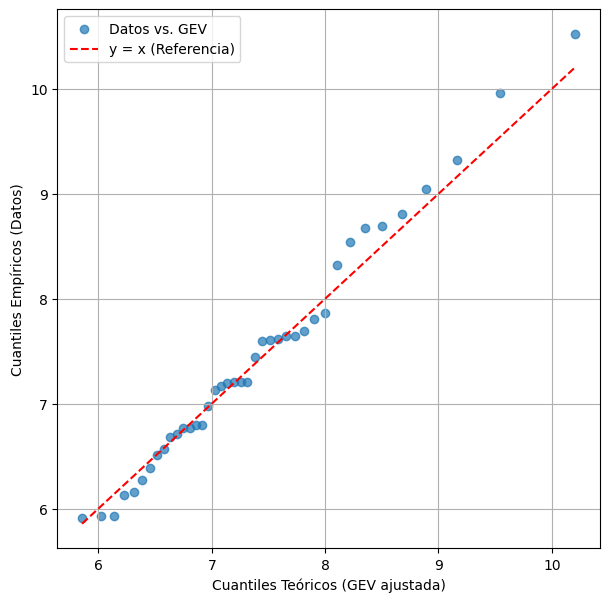

In [360]:
folder_path = "Figuras/Hs/AnnualMax"

n = len(max_all_data_hist)
probabilities = (np.arange(1, n + 1)) / (n+1)  # Probabilidades de los cuantiles empíricos
gev_quantiles = stats.genextreme.ppf(probabilities, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)

# Crear el QQ-plot
plt.figure(figsize=(7, 7))
plt.scatter(gev_quantiles, max_all_data_hist_sort, label="Datos vs. GEV", alpha=0.7)
plt.plot(gev_quantiles, gev_quantiles, 'r--', label="y = x (Referencia)")

# Etiquetas
plt.xlabel("Cuantiles Teóricos (GEV ajustada)")
plt.ylabel("Cuantiles Empíricos (Datos)")
# plt.title("QQ-plot: Ajuste de la GEV a los Datos")
plt.legend()
plt.grid()
plt.savefig(f"{folder_path}/QQPlot_All.png", dpi=200)
plt.show()
plt.close()

#### Extremal correction

In [364]:
# --- 1. Precompute / store repeated values in a variable ---
peak_values = max_all_data_hist_sort
daily_hs = df_hs['Hs'].values
n_peaks = len(peak_values)
n_daily = len(daily_hs)

# --- 2. Empirical peak probabilities + GEV quantiles ---
aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
ecdf_annmax_probs_hist_all = aux_ecdf_pot_probs
# GPD-corrected peaks
corrected_peaks = stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)
hs_annmax_corrected_hist_all = corrected_peaks

# --- 3. Vectorized correction of the daily data ---
#     Only correct those daily Hs >= the first threshold peak; 
#     below that, they remain as is. For values above the last peak, 
#     we clamp them to the last corrected peak. Otherwise, we do a 
#     linear interpolation between consecutive peaks.
aux_hs_corrected = daily_hs.copy()  # copy original array

if n_peaks > 1:
    # Create a boolean mask for values above the first “peak_values[0]”
    above_mask = aux_hs_corrected > peak_values[0]
    # Clip these “above” values so that anything larger than peak_values[-1]
    # is just pinned at peak_values[-1]. This replicates your code’s logic:
    #   daily_value >= last peak => daily_value = corrected_peaks[-1].
    clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
    
    # Interpolate them onto the corrected peak range
    # By default, np.interp returns the left/right endpoint values
    # for out-of-bounds data. Since we clipped above, no extrapolation needed.
    aux_hs_corrected[above_mask] = np.interp(
        clipped_vals,         # x-coords to interpolate
        peak_values,          # x-coords of data points
        corrected_peaks       # y-coords of data points
    )

hs_corrected_hist_all = aux_hs_corrected

# --- 4. Compute probabilities & return periods ---
#     (Same as your original code, but using local variables 
#      to make it more readable.)

# GPD fit over a grid of x-values
x_vals = np.linspace(corrected_peaks[0], corrected_peaks[-1], 1000)
x_values_gev_hist_all = x_vals
# Return period from GPD fit
cdf_gev = stats.genextreme.cdf(x_vals, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)
fitted_return_perd_values_gev_hist_all = 1.0 / (1.0 - cdf_gev) *(40/n_peaks)

# Corrected peaks: re-check CDF and return periods
cdf_corrected = stats.genextreme.cdf(
    stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all),
    shape_gev_all, loc=loc_gev_all, scale=scale_gev_all
)
ecdf_annmax_probs_corrected_hist_all = cdf_corrected
T_ev_corrected_hist_all = 1.0 / (1.0 - cdf_corrected) *(40/n_peaks)

# Daily corrected data
ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
ecdf_pt_probs_corrected_hist_all = ecdf_pt_probs_corrected
T_pt_corrected_hist_all = 1.0 / (1.0 - ecdf_pt_probs_corrected) / 365.25

# POT (uncorrected)
T_pot_hist_all = 1.0 / (1.0 - aux_ecdf_pot_probs) *(40/n_peaks)

# Daily data (uncorrected)
ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
ecdf_pt_probs_wt_hist_all = ecdf_pt_probs_wt
T_pt_wt_hist_all = 1.0 / (1.0 - ecdf_pt_probs_wt) / 365.25

# Confidence intervals
# dqgev[wt] = dq_gev(ecdf_annmax_probs_hist[wt], xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt, quanval=quanval)
dqgev_all = dq_gev_nuevo(ecdf_annmax_probs_hist_all, p=[loc_gev_all, scale_gev_all, shape_gev_all])
# _,_,hessians_gev[wt] = loglikelihood_gev(peak_values, xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt)
aux_fun = lambda x: nll(max_all_data_hist, x)
hess = ndt.Hessian(aux_fun)
hessians_gev_all = hess([loc_gev_all, scale_gev_all, shape_gev_all])
invI0_gev_all = np.linalg.inv(hessians_gev_all)

stdDq_gev_all = np.sqrt(np.sum((dqgev_all.T@invI0_gev_all) * dqgev_all.T, axis=1)) # Es lo mismo 
stdup_gev_all = hs_annmax_corrected_hist_all + stdDq_gev_all*stats.norm.ppf(1-(1-quanval)/2,0,1)
stdlo_gev_all = hs_annmax_corrected_hist_all - stdDq_gev_all*stats.norm.ppf(1-(1-quanval)/2,0,1)

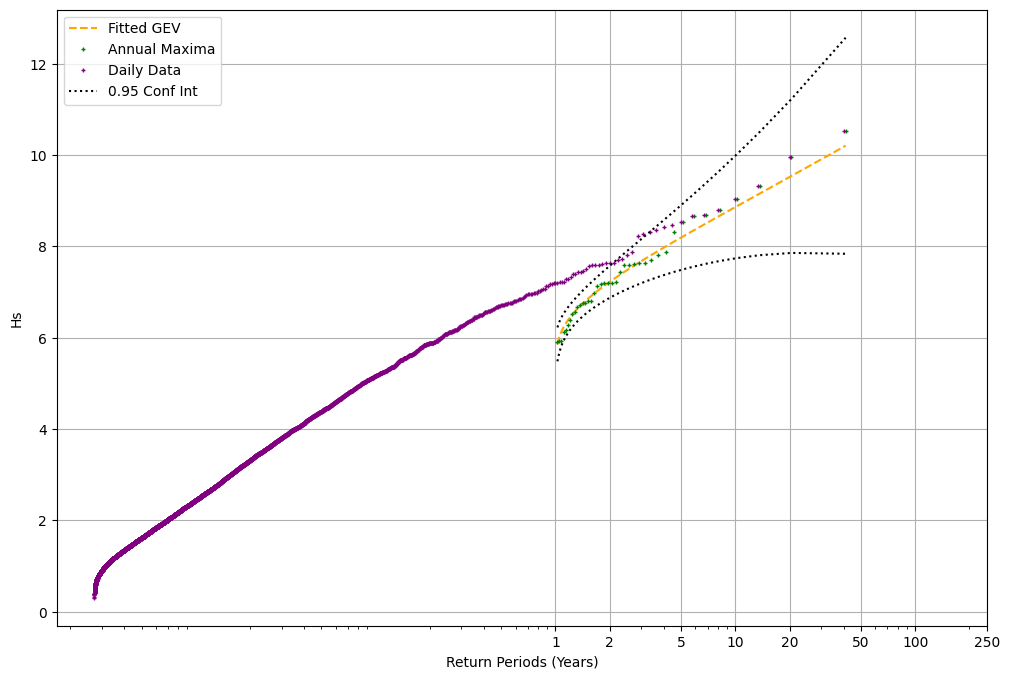

In [365]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()
ax.semilogx(fitted_return_perd_values_gev_hist_all, np.sort(x_values_gev_hist_all), color = 'orange',linestyle='dashed', label='Fitted GEV')
# ax.semilogx(T_pt_corrected_hist[wt], np.sort(hs_corrected_hist[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
# ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima ($H_s$)')

# Si representamos los datos sin corregir
ax.semilogx(T_pot_hist_all, max_all_data_hist_sort, color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')
ax.semilogx(T_pt_wt_hist_all, np.sort(df_hs['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')


# Confidence interval for fitted GEV
ax.semilogx(T_ev_corrected_hist_all, stdup_gev_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax.semilogx(T_ev_corrected_hist_all, stdlo_gev_all, color = "black",linestyle='dotted')

ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel("Hs")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(right=250)
ax.legend()
ax.grid()
plt.savefig(f"{folder_path}/CorrectionAnn_ReturnPeriod.png", dpi=300)
plt.show()
plt.close()

#### Corrección de datos simulados

In [368]:
hs_simulated_data = simulated_df.fillna(0)
# Obtaining annual maxima and indices associated
max_all_data_sim = hs_simulated_data.groupby(["year"], as_index=False)["Hs"].max()["Hs"].values
max_all_idx_sim = hs_simulated_data.groupby(["year"])["Hs"].idxmax().values
max_all_data_sim_sort = np.sort(max_all_data_sim)
max_all_idx_sim_sort = np.argsort(max_all_data_sim)

In [369]:
# --- 1. Precompute / store repeated values in a variable ---
peak_values = max_all_data_sim_sort
daily_hs = hs_simulated_data['Hs'].values
n_peaks = len(peak_values)
n_daily = len(daily_hs)

# --- 2. Empirical peak probabilities + GEV quantiles ---
aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
ecdf_annmax_probs_sim_all = aux_ecdf_pot_probs
# GPD-corrected peaks
corrected_peaks = stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)
hs_annmax_corrected_sim_all = corrected_peaks

# --- 3. Vectorized correction of the daily data ---
#     Only correct those daily Hs >= the first threshold peak; 
#     below that, they remain as is. For values above the last peak, 
#     we clamp them to the last corrected peak. Otherwise, we do a 
#     linear interpolation between consecutive peaks.
aux_hs_corrected = daily_hs.copy()  # copy original array

if n_peaks > 1:
    # Create a boolean mask for values above the first “peak_values[0]”
    above_mask = aux_hs_corrected > peak_values[0]
    # Clip these “above” values so that anything larger than peak_values[-1]
    # is just pinned at peak_values[-1]. This replicates your code’s logic:
    #   daily_value >= last peak => daily_value = corrected_peaks[-1].
    clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
    
    # Interpolate them onto the corrected peak range
    # By default, np.interp returns the left/right endpoint values
    # for out-of-bounds data. Since we clipped above, no extrapolation needed.
    aux_hs_corrected[above_mask] = np.interp(
        clipped_vals,         # x-coords to interpolate
        peak_values,          # x-coords of data points
        corrected_peaks       # y-coords of data points
    )

hs_corrected_sim_all = aux_hs_corrected

# --- 4. Compute probabilities & return periods ---
#     (Same as your original code, but using local variables 
#      to make it more readable.)

# GPD fit over a grid of x-values
x_vals = np.linspace(corrected_peaks[0], corrected_peaks[-1], 1000)
x_values_gev_sim_all = x_vals
# Return period from GPD fit
cdf_gev = stats.genextreme.cdf(x_vals, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)
fitted_return_perd_values_gev_sim_all = 1.0 / (1.0 - cdf_gev) #*(40/len(max_all_data_hist_sort))#(10000/n_peaks)

# Corrected peaks: re-check CDF and return periods
cdf_corrected = stats.genextreme.cdf(
    stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all),
    shape_gev_all, loc=loc_gev_all, scale=scale_gev_all
)
ecdf_annmax_probs_corrected_sim_all = cdf_corrected
T_ev_corrected_sim_all = 1.0 / (1.0 - cdf_corrected) #*(40/len(max_all_data_hist_sort))#(10000/n_peaks)

# Daily corrected data
ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
ecdf_pt_probs_corrected_sim_all = ecdf_pt_probs_corrected
T_pt_corrected_sim_all = 1.0 / (1.0 - ecdf_pt_probs_corrected) / 365.25

# POT (uncorrected)
T_pot_sim_all = 1.0 / (1.0 - aux_ecdf_pot_probs) #*(40/len(max_all_data_hist_sort))#(10000/n_peaks)

# Daily data (uncorrected)
ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
ecdf_pt_probs_wt_sim_all = ecdf_pt_probs_wt
T_pt_wt_sim_all = 1.0 / (1.0 - ecdf_pt_probs_wt) / 365.25

# Confidence intervals
dqgev_sim_all = dq_gev_nuevo(ecdf_annmax_probs_sim_all, p=[loc_gev_all, scale_gev_all, shape_gev_all])
aux_fun = lambda x: nll(max_all_data_hist, x)
hess = ndt.Hessian(aux_fun)
hessians_gev_sim_all = hess([loc_gev_all, scale_gev_all, shape_gev_all])
invI0_gev_sim_all = np.linalg.inv(hessians_gev_sim_all)

stdDq_gev_sim_all = np.sqrt(np.sum((dqgev_sim_all.T@invI0_gev_sim_all) * dqgev_sim_all.T, axis=1)) # Es lo mismo 
stdup_gev_sim_all = hs_annmax_corrected_sim_all + stdDq_gev_sim_all*stats.norm.ppf(1-(1-quanval)/2,0,1)
stdlo_gev_sim_all = hs_annmax_corrected_sim_all - stdDq_gev_sim_all*stats.norm.ppf(1-(1-quanval)/2,0,1)

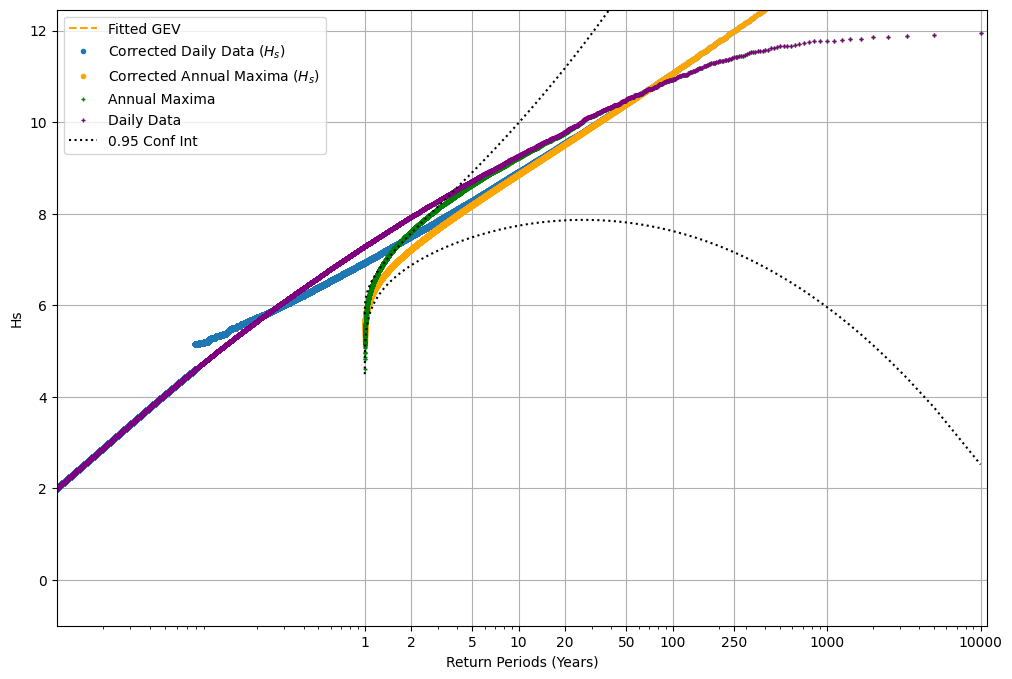

In [370]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()
ax.semilogx(fitted_return_perd_values_gev_sim_all, np.sort(x_values_gev_sim_all), color = 'orange',linestyle='dashed', label='Fitted GEV')
ax.semilogx(T_pt_corrected_sim_all, np.sort(hs_corrected_sim_all), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
ax.semilogx(T_ev_corrected_sim_all, stats.genextreme.ppf(ecdf_annmax_probs_sim_all, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima ($H_s$)')

# Si representamos los datos sin corregir
ax.semilogx(T_pot_sim_all, max_all_data_sim_sort, color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')
ax.semilogx(T_pt_wt_sim_all, np.sort(hs_simulated_data['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

# Confidence Interval
ax.semilogx(T_ev_corrected_sim_all, stdup_gev_sim_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax.semilogx(T_ev_corrected_sim_all, stdlo_gev_sim_all, color = "black",linestyle='dotted')


ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel("Hs")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
# ax.set_xlim(right=10100)
ax.legend()
ax.grid()
ax.set_xlim(left=0.01, right=11000)
ax.set_ylim(bottom=-1, top=simulated_df["Hs"].max()+0.5)
plt.savefig(f"{folder_path}/Simulated_CorrectionAnn_Hs_ReturnPeriod_All.png", dpi=300)
plt.show()
plt.close()

#### Serie historica con bandas de confianza y serie simulada cada 40 años

In [373]:
max_idx_sim_40years_all = {}
for i_year in range(10000//40):
    max_idx_sim_40years_all[i_year] = hs_simulated_data[(2000+40*i_year< hs_simulated_data['year']) & (hs_simulated_data['year'] <= 2000+40*(i_year+1))].groupby(["year"])["Hs"].idxmax().values

In [377]:
# 40 by 40 years
new_max_idx_sim_100_all = {}
annual_maxima_corrected_sim_100_all = {}
ecdf_annual_maxima_sim_100_all = {}
T_ecdf_annual_maxima_sim_100_all = {}
# Sin corregir
annual_maxima_nocorrected_sim_100_all = {}
ecdf_annual_maxima_sim_100_nocorr_all = {}
T_ecdf_annual_maxima_sim_100_nocorr_all = {}
for i_year in range(10000//40):
    new_max_idx_sim_100_all[i_year] = hs_simulated_data["Hs"].index.get_indexer(max_idx_sim_40years_all[i_year])
    annual_maxima_corrected_sim_100_all[i_year] = hs_corrected_sim_all[new_max_idx_sim_100_all[i_year]]
    ecdf_annual_maxima_sim_100_all[i_year] = np.arange(1,len(annual_maxima_corrected_sim_100_all[i_year])+1)/(len(annual_maxima_corrected_sim_100_all[i_year])+1)
    T_ecdf_annual_maxima_sim_100_all[i_year] = 1/(1-ecdf_annual_maxima_sim_100_all[i_year])*(40/len(new_max_idx_sim_100_all[i_year]))
    # Sin corregir
    annual_maxima_nocorrected_sim_100_all[i_year] = hs_simulated_data["Hs"][max_idx_sim_40years_all[i_year]].values
    ecdf_annual_maxima_sim_100_nocorr_all[i_year] = np.arange(1,len(annual_maxima_nocorrected_sim_100_all[i_year])+1)/(len(annual_maxima_nocorrected_sim_100_all[i_year])+1)
    T_ecdf_annual_maxima_sim_100_nocorr_all[i_year] = 1/(1-ecdf_annual_maxima_sim_100_nocorr_all[i_year])*(40/len(max_idx_sim_40years_all[i_year]))

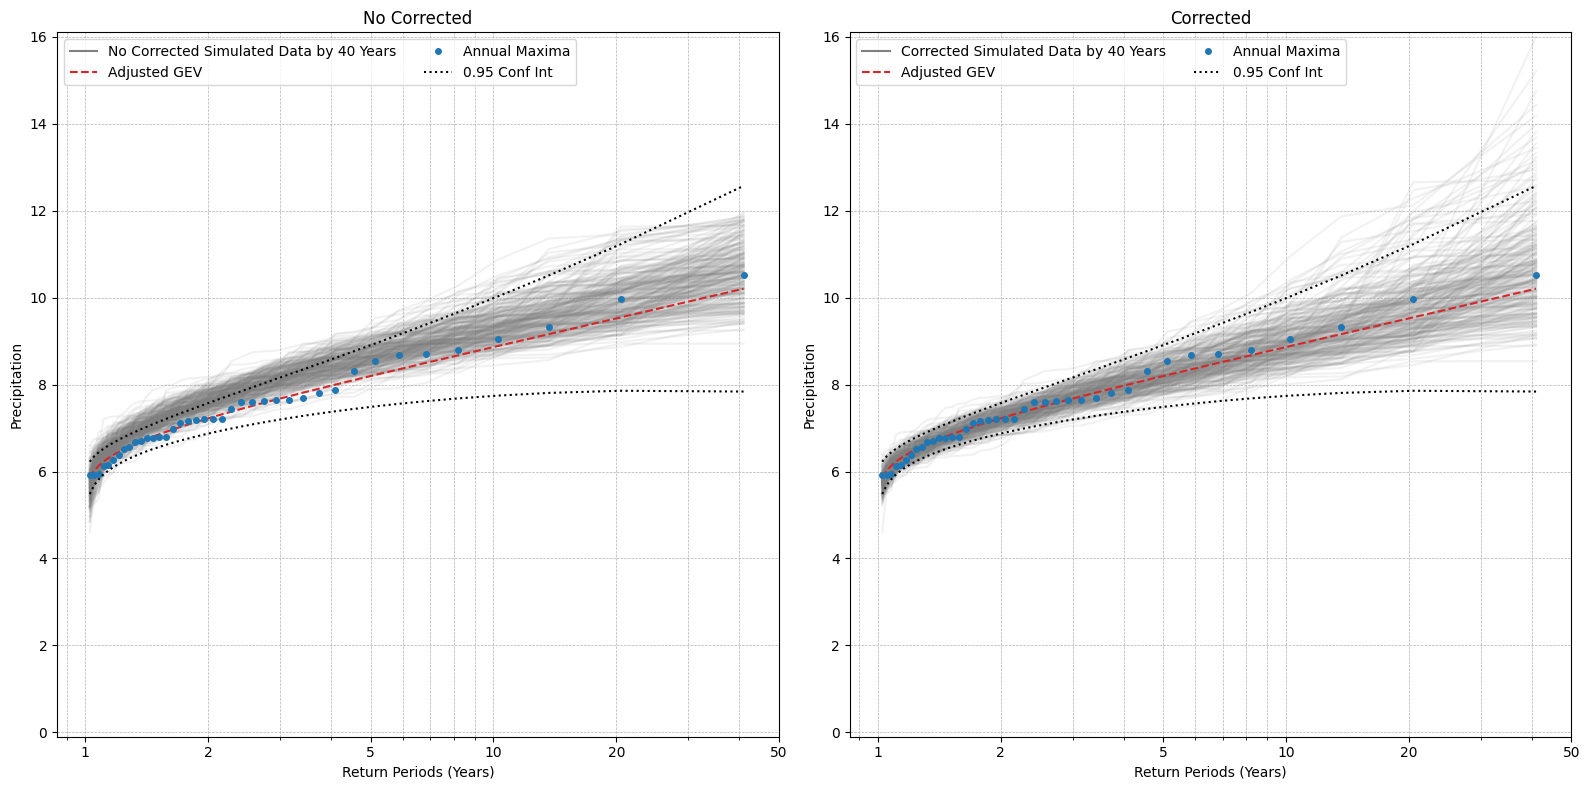

In [379]:
fig = plt.figure(figsize=(16,8))
ax1= fig.add_subplot(121)   
ax2= fig.add_subplot(122)   

# ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
# ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
# ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

# Si representamos los datos sin corregir
# ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
# ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

# Serie simulada 40 por 40 años CORREGIDA
max2 = []
max2.append(np.max(annual_maxima_corrected_sim_100_all[0]))
ax2.semilogx(T_ecdf_annual_maxima_sim_100_all[0], np.sort(annual_maxima_corrected_sim_100_all[0]), color = "tab:gray", alpha = 0.1, label="Corrected Simulated Data by 40 Years")
for i_year in range(1,10000//40):
    max2.append(np.max(annual_maxima_corrected_sim_100_all[i_year]))
    ax2.semilogx(T_ecdf_annual_maxima_sim_100_all[i_year], np.sort(annual_maxima_corrected_sim_100_all[i_year]), color = "tab:gray", alpha = 0.1)

# Serie simulada 40 por 40 años SIN CORREGIR
max1 = []
max1.append(np.max(annual_maxima_nocorrected_sim_100_all[0]))
ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr_all[0], np.sort(annual_maxima_nocorrected_sim_100_all[0]), color = "tab:gray", alpha = 0.1, label="No Corrected Simulated Data by 40 Years")
for i_year in range(1,10000//40):
    max1.append(np.max(annual_maxima_nocorrected_sim_100_all[i_year]))
    ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr_all[i_year], np.sort(annual_maxima_nocorrected_sim_100_all[i_year]), color = "tab:gray", alpha = 0.1)


# Annual Return Periods
# ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), 
#             color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
ax1.semilogx(fitted_return_perd_values_gev_hist_all, np.sort(x_values_gev_hist_all), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
ax1.semilogx(T_pot_hist_all, max_all_data_hist_sort, color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')

ax2.semilogx(fitted_return_perd_values_gev_hist_all, np.sort(x_values_gev_hist_all), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
ax2.semilogx(T_pot_hist_all, max_all_data_hist_sort, color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')

# Confidence intervals
ax1.semilogx(T_ev_corrected_hist_all, stdup_gev_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax1.semilogx(T_ev_corrected_hist_all, stdlo_gev_all, color = "black",linestyle='dotted')

ax2.semilogx(T_ev_corrected_hist_all, stdup_gev_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax2.semilogx(T_ev_corrected_hist_all, stdlo_gev_all, color = "black",linestyle='dotted')



ax1.set_xlabel("Return Periods (Years)")
ax1.set_ylabel("Precipitation")
ax1.set_xscale('log')
ax1.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
leg1 = ax1.legend(loc='upper left', ncol=2)
for lh in leg1.legend_handles:
    lh.set_alpha(1)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
ax1.set_xlim(right=50)
ax1.set_title("No Corrected")


ax2.set_xlabel("Return Periods (Years)")
ax2.set_ylabel("Precipitation")
ax2.set_xscale('log')
ax2.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())
leg2 = ax2.legend(loc='upper left', ncol=2)
for lh in leg2.legend_handles:
    lh.set_alpha(1)
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
ax2.set_xlim(right=50)
ax2.set_title("Corrected")

fig.tight_layout()
plt.savefig(f"{folder_path}/HistoricalData_40ySimulatedAll_ReturnPeriod_All.png", dpi=300)
plt.show()
plt.close()

### Periodos de retorno máximos anuales corregidos juntando todos los WT. 

Usar los datos corregidos de la simulación corregidos para cada WT para pintar los máximos anuales de la serie completa.

In [422]:
aux_hs_corrected_sim_all = []
aux_year_corrected_sim_all = []
aux_month_corrected_sim_all = []
aux_day_corrected_sim_all = []
aux_wt_corrected_sim_all = []
for wt in unique_rwt[:-4]:
    aux_hs_corrected_sim_all.extend(hs_corrected_sim[wt])
    aux_year_corrected_sim_all.extend(dict_hs_sim[wt]['year'].values)
    aux_month_corrected_sim_all.extend(dict_hs_sim[wt]['month'].values)
    aux_day_corrected_sim_all.extend(dict_hs_sim[wt]['day'].values)
    aux_wt_corrected_sim_all.extend(dict_hs_sim[wt]['wt'].values)

# ESTOS NO SE HAN CORREGIDO
for wt in unique_rwt[-4:]:
    aux_hs_corrected_sim_all.extend(dict_hs_sim[wt]['Hs'].values)
    aux_year_corrected_sim_all.extend(dict_hs_sim[wt]['year'].values)
    aux_month_corrected_sim_all.extend(dict_hs_sim[wt]['month'].values)
    aux_day_corrected_sim_all.extend(dict_hs_sim[wt]['day'].values)
    aux_wt_corrected_sim_all.extend(dict_hs_sim[wt]['wt'].values)

df_corrected_simulation = pd.DataFrame({
    'Hs_corr': aux_hs_corrected_sim_all, 
    'year': aux_year_corrected_sim_all, 
    'month': aux_month_corrected_sim_all, 
    'day': aux_day_corrected_sim_all, 
    'wt': aux_wt_corrected_sim_all, 
})

In [423]:
maximos_anuales_corregidos_all = df_corrected_simulation.groupby(["year"], as_index=False)["Hs_corr"].max()["Hs_corr"].values
ecdf_maximos_anuales_corregidos_all = np.arange(1,len(maximos_anuales_corregidos_all)+1)/(len(maximos_anuales_corregidos_all)+1)
T_empirical_maximos_anuales_corregidos_all = 1/(1-ecdf_maximos_anuales_corregidos_all)

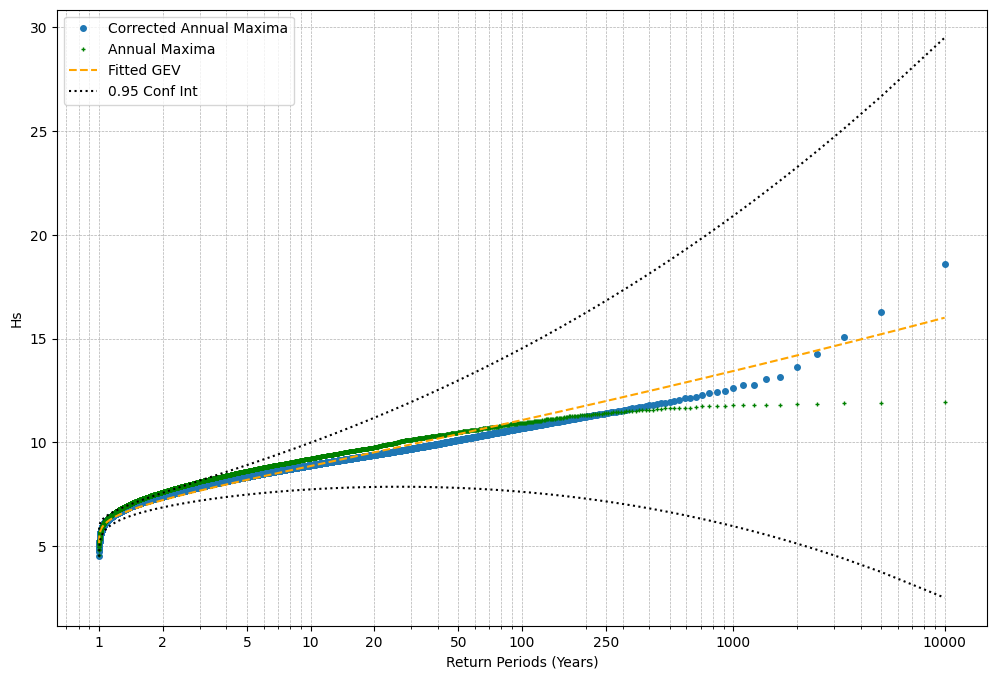

In [431]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.semilogx(T_empirical_maximos_anuales_corregidos_all, np.sort(maximos_anuales_corregidos_all), color="tab:blue", linewidth=0, marker='o',markersize=4, label='Corrected Annual Maxima')
# ax.semilogx(T_empirical_maximos_anuales_corregidos_all, max_all_data_sim_sort, color="green", linewidth=0, marker='+',markersize=4, label='Annual Maxima')
ax.semilogx(T_pot_sim_all, max_all_data_sim_sort, color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')


ax.semilogx(fitted_return_perd_values_gev_sim_all, np.sort(x_values_gev_sim_all), color = 'orange',linestyle='dashed', label='Fitted GEV')
# Confidence Interval
ax.semilogx(T_ev_corrected_sim_all, stdup_gev_sim_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax.semilogx(T_ev_corrected_sim_all, stdlo_gev_sim_all, color = "black",linestyle='dotted')

ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel("Hs")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.legend()
plt.savefig(f"{folder_path}/CorrectedAllWT_ReturnPeriod.png", dpi=300)
plt.show()
plt.close()

Dividido por años

In [429]:
# 40 by 40 years
new_max_idx_sim_100_all = {}
annual_maxima_corrected_sim_100_all_wt = {}
ecdf_annual_maxima_sim_100_all_wt = {}
T_ecdf_annual_maxima_sim_100_all_wt = {}
# Sin corregir
annual_maxima_nocorrected_sim_100_all = {}
ecdf_annual_maxima_sim_100_nocorr_all = {}
T_ecdf_annual_maxima_sim_100_nocorr_all = {}
for i_year in range(10000//40):
    new_max_idx_sim_100_all[i_year] = hs_simulated_data["Hs"].index.get_indexer(max_idx_sim_40years_all[i_year])

    annual_maxima_corrected_sim_100_all_wt[i_year] = maximos_anuales_corregidos_all[40*i_year:40*(i_year+1)]
    ecdf_annual_maxima_sim_100_all_wt[i_year] = np.arange(1,len(annual_maxima_corrected_sim_100_all_wt[i_year])+1)/(len(annual_maxima_corrected_sim_100_all_wt[i_year])+1)
    T_ecdf_annual_maxima_sim_100_all_wt[i_year] = 1/(1-ecdf_annual_maxima_sim_100_all_wt[i_year])*(40/len(max_idx_sim_40years_all[i_year]))
    # Sin corregir
    annual_maxima_nocorrected_sim_100_all[i_year] = hs_simulated_data["Hs"][max_idx_sim_40years_all[i_year]].values
    ecdf_annual_maxima_sim_100_nocorr_all[i_year] = np.arange(1,len(annual_maxima_nocorrected_sim_100_all[i_year])+1)/(len(annual_maxima_nocorrected_sim_100_all[i_year])+1)
    T_ecdf_annual_maxima_sim_100_nocorr_all[i_year] = 1/(1-ecdf_annual_maxima_sim_100_nocorr_all[i_year])*(40/len(max_idx_sim_40years_all[i_year]))

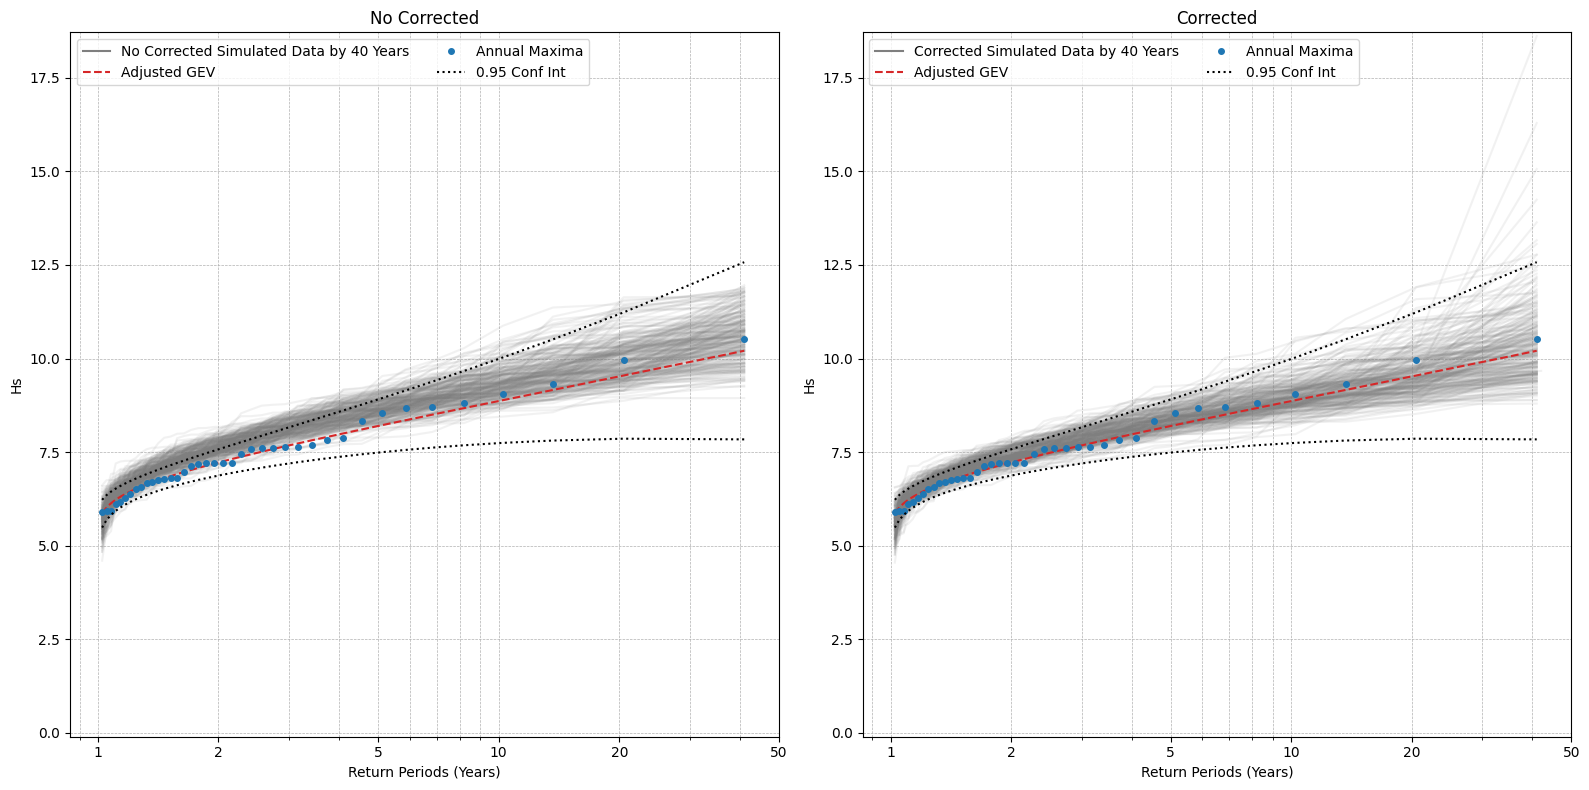

In [434]:
fig = plt.figure(figsize=(16,8))
ax1= fig.add_subplot(121)   
ax2= fig.add_subplot(122)   

# ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
# ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
# ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

# Si representamos los datos sin corregir
# ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
# ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

# Serie simulada 40 por 40 años CORREGIDA
max2 = []
max2.append(np.max(annual_maxima_corrected_sim_100_all_wt[0]))
ax2.semilogx(T_ecdf_annual_maxima_sim_100_all_wt[0], np.sort(annual_maxima_corrected_sim_100_all_wt[0]), color = "tab:gray", alpha = 0.1, label="Corrected Simulated Data by 40 Years")
for i_year in range(1,10000//40):
    max2.append(np.max(annual_maxima_corrected_sim_100_all_wt[i_year]))
    ax2.semilogx(T_ecdf_annual_maxima_sim_100_all_wt[i_year], np.sort(annual_maxima_corrected_sim_100_all_wt[i_year]), color = "tab:gray", alpha = 0.1)

# Serie simulada 40 por 40 años SIN CORREGIR
max1 = []
max1.append(np.max(annual_maxima_nocorrected_sim_100_all[0]))
ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr_all[0], np.sort(annual_maxima_nocorrected_sim_100_all[0]), color = "tab:gray", alpha = 0.1, label="No Corrected Simulated Data by 40 Years")
for i_year in range(1,10000//40):
    max1.append(np.max(annual_maxima_nocorrected_sim_100_all[i_year]))
    ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr_all[i_year], np.sort(annual_maxima_nocorrected_sim_100_all[i_year]), color = "tab:gray", alpha = 0.1)


# Annual Return Periods
# ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), 
#             color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
ax1.semilogx(fitted_return_perd_values_gev_hist_all, np.sort(x_values_gev_hist_all), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
ax1.semilogx(T_pot_hist_all, max_all_data_hist_sort, color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')

ax2.semilogx(fitted_return_perd_values_gev_hist_all, np.sort(x_values_gev_hist_all), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
ax2.semilogx(T_pot_hist_all, max_all_data_hist_sort, color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')

# Confidence intervals
ax1.semilogx(T_ev_corrected_hist_all, stdup_gev_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax1.semilogx(T_ev_corrected_hist_all, stdlo_gev_all, color = "black",linestyle='dotted')

ax2.semilogx(T_ev_corrected_hist_all, stdup_gev_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax2.semilogx(T_ev_corrected_hist_all, stdlo_gev_all, color = "black",linestyle='dotted')



ax1.set_xlabel("Return Periods (Years)")
ax1.set_ylabel("Hs")
ax1.set_xscale('log')
ax1.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
leg1 = ax1.legend(loc='upper left', ncol=2)
for lh in leg1.legend_handles:
    lh.set_alpha(1)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
ax1.set_xlim(right=50)
ax1.set_title("No Corrected")


ax2.set_xlabel("Return Periods (Years)")
ax2.set_ylabel("Hs")
ax2.set_xscale('log')
ax2.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())
leg2 = ax2.legend(loc='upper left', ncol=2)
for lh in leg2.legend_handles:
    lh.set_alpha(1)
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
ax2.set_xlim(right=50)
ax2.set_title("Corrected")

fig.tight_layout()
# plt.savefig(f"{folder_path}/HistoricalData_40ySimulatedAll_ReturnPeriod_All.png", dpi=300)
plt.savefig(f"{folder_path}/HistoricalData_40ySimulatedAll_ReturnPeriod_JointWT.png", dpi=300)
plt.show()
plt.close()